In [1]:
#import packages used for the problems

import numpy as np #comment: numerical package
import matplotlib.pyplot as plt #comment: plotting package
import corner #comment: to plot corner plots
from scipy import optimize #comment: versatile optimization tool: https://docs.scipy.org/doc/scipy/tutorial/optimize.html
from scipy import interpolate as intpo #comment: https://docs.scipy.org/doc/scipy/reference/interpolate.html
import scipy as sp #comment: collection of mathematical algorithms https://docs.scipy.org/doc/scipy/
from numba import jit #comment: numba optimizes functions for machine runtime. jit is a decorator that tags the function in question https://numba.pydata.org/
import pickle #comment: to save your code and its results as is in a binary format file "*.p".
import time
import emcee  #comment: sampler https://emcee.readthedocs.io/en/stable/ 
from math import pi, e #comment: mathematical constants
import uncertainties
from uncertainties import umath
import pandas as pd #comment: data analysis tool https://pandas.pydata.org/ 
from astropy.table import Table
from multiprocessing import Pool
from IPython.display import Math
import copy


In [2]:
#define a class of constants useful for Galactic Center science

class constants:
    """
    Class for keeping track of physical constants and quantities.
    """
    def __init__(self):
        """
        Setting constants and quantities at class initialization.
        """
        #UNIVERSAL CONSTANTS ARE DEFINED HERE

        #TIME REFERENCE
        self.J2000=51544.5 # in MJD

        #UNITS OF DISTANCE
        self.AU2KM=149597870.700
        self.pc2AU=206263.36898396

        #UNITS OF TIME
        self.YR2DAY = 365.25
        self.YR2MIN = 365.25*1440.
        self.YR2SEC=365.25*86400.

        #UNITS OF VELOCITY
        self.AUYR2KMS=self.AU2KM/self.YR2SEC

        #UNITS OF ENERGY
        self.JOULE2GEV = 6241506479.9632
        self.JOULE2KEV = self.JOULE2GEV * 1.e6
        self.PLANCK = 6.626070150e-34 #J*s
        self.solarlum = 3.828e26 #W
        self.k  = 1.38064852e-23 #m^2*kg/s^2/K

        #GM
        self.GMSUN=365.25*365.25*0.2959122082855911e-3 # Kg * AU^3 / yr^2
        self.GMSUN_4pi2=self.GMSUN/(4.*pi*pi)

        #SPEED OF LIGHT
        self.CKMS=299792.458        # speed of light in km/s
        self.CAUYR=self.CKMS/self.AUYR2KMS  # speed of ligh in AU/yr

        #OTHERS
        self.SIGMA2FWHM=2.*np.sqrt(2.*np.log(2.))
        self.RAD2DEG = 180./pi
        self.RAD2AS = self.RAD2DEG * 3600.
        self.AS2MAS=1000.
        self.GAUSS2MICROGAUSS = 1.e6
        self.KM2M = 1.e3
        self.MHZ2GHZ = 1.e-3
        self.GHZ2HZ = 1.e9

        #SYNCHROTRON CONSTANTS
        self.C3INV = 8.352e9 #[yr * uG^2 * GeV]
        self.C1 = 16.08 #[MHz / (uG * GeV^2)]
        self.C2INV = 32.* pi*pi / (9.*np.sqrt(3)) * self.C3INV * self.C1 #[uG *Sr / GeV * MHZ * yr]
        self.C2 = 1/self.C2INV / 3.154e13 #[Gev / uG / Sr]
        self.C3 = 1/self.C3INV
        self.LAMBDA2SRPERMICROGAUSS = np.sqrt(pi)/2. * (1./ self.AS2MAS / self.RAD2AS) \
        								/self.GAUSS2MICROGAUSS**(1./4.)
        #factor in lamda equation
        self.k1 = (self.CKMS * self.KM2M)**(2.) * 1.e-12*16.08**0.5*1.e-3 * 1.e-26 \
        			*self.JOULE2GEV*4./pi * self.AS2MAS**2. * self.RAD2AS**2.

        #DISTANCE OF SGR A* (GRAVITY redhift paper: https://arxiv.org/pdf/1904.05721.pdf)
        self.DISTSGRAPC = 8178. #pc
        self.DISTSGRAAU = self.DISTSGRAPC * self.pc2AU
        self.DISTSGRAKM= self.DISTSGRAAU * self.AU2KM
        self.DISTSGRAM= self.DISTSGRAKM * 1000.

        #2GM/c^2 SGRA*
        self.SCHWRADM = 1.2e10 #[m]
        self.SCHWRADAU = self.SCHWRADM / self.AU2KM / 1000. #[AU]

        #ELECTRON MASS [kg]
        self.me = 9.10938356e-31

        #submm, NIR, and X-ray frequencies [GHz]
        self.freq_2_2_um = 136269.299
        self.freq_3_7_um = 79310.174
        self.freq_4_5_um = 66620.546


		#S0-2 semi-major axis = 0.1226 arcsec

# Problem 1 - random distributions in numpy

(10000, 6)
(10000,)


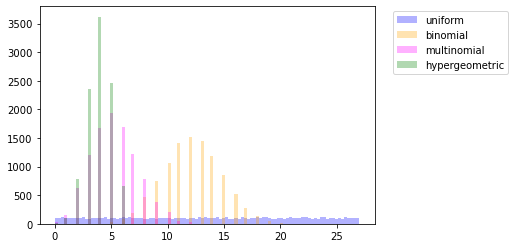

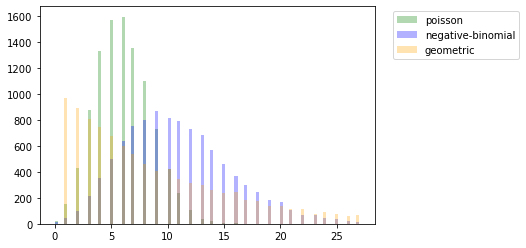

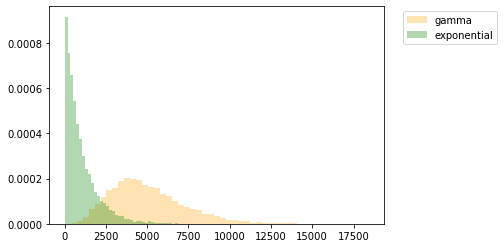

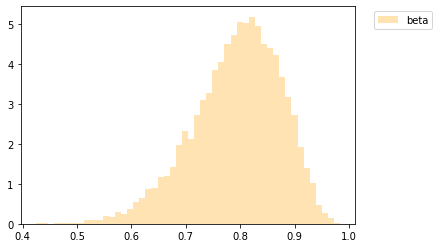

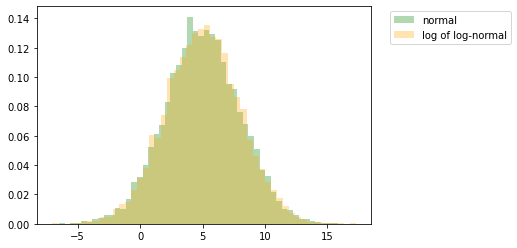

In [81]:
#------------------------------------------------
#exercise 1.1: 
#------------------------------------------------


n_sampl = 10000 # number of samples

#generate n uniformly distributed numbers on [0,27[ 
u = 27. * np.random.random([n_sampl])

#------------------------------------------------
#exercise 1.2: 
#------------------------------------------------

# repeated coin toss: sampling the number k of positive outcomes for n random draws with possible outcome {0,1}
#(think ) and probabiity p for success; assuming n = 27, and p = 0.45 we get:
n = 27
p = 0.45
bn = np.random.binomial(n, p, size = n_sampl)

#------------------------------------------------
#exercise 1.3: 
#------------------------------------------------

# repeated draw of ball from an urn with replacement: draw 27 times, there are 6 colors of balls with 
# different probabilities for each color p_i that have to sum up to unity:
mn = np.random.multinomial(27, [2./36.,4./36.,8./36.,12./36.,7./36.,3./36.], size = n_sampl)
print(mn.shape)

#------------------------------------------------
#exercise 1.4: 
#------------------------------------------------

# repeated draw of ball from an urn without replacement OR simultaneous draw; here the version 
#for only two classes of objects ('good' and 'bad'), like in the lottery 6 out of 49 (German reference :) ).
# This radom function samples the number of good outcomes (like the binomial distribution):
hg = np.random.hypergeometric(6, 35, 27, size = n_sampl)
print(hg.shape)

#------------------------------------------------
#exercise 1.5: 
#------------------------------------------------

# number of rare events per time interval; let's assume an average countrate of c = 0.0017 cps, and a time 
#interval of delta_t = 100 min:
c = 0.001
delta_t = 6000.
lam = c*delta_t
poi = np.random.poisson(lam, size = n_sampl)

#------------------------------------------------
#exercise 1.6: 
#------------------------------------------------

# Waiting time (discrete) distribution of two color urn drawings with replacement; how much longer than r drawings must I wait 
# until I get r successes? 
r = 9
p = 0.45
nbn = np.random.negative_binomial(r, p, size = n_sampl)

#------------------------------------------------
#exercise 1.7: 
#------------------------------------------------

# Waiting time (discrete) distribution for the first success, as before but with r = 1:
p = 0.1
geo = np.random.geometric(p, size = n_sampl)

#------------------------------------------------
#exercise 1.8: 
#------------------------------------------------

# Waiting time (continuous) distribution for the rth event with rate c:
c = 0.001
r = 5
gam = np.random.gamma(r, 1./c, size = n_sampl)
# Waiting time (continuous) distribution for the first event with rate c:
ex = np.random.exponential( 1./c, size = n_sampl)

#------------------------------------------------
#exercise 1.9: 
#------------------------------------------------

#Waiting time (continuous) distribution for the rth event when n events will certainly happen within 
#the unit time interval:
n = 22.7
r = 18.8
be = np.random.beta(r, n-r+1, size = n_sampl)

#------------------------------------------------
#exercise 1.10: 
#------------------------------------------------

# The normal distribution:
m = 5.
v = 3.
norm = np.random.normal(m, v, size = n_sampl)

#------------------------------------------------
#exercise 1.11: 
#------------------------------------------------

# Sampling from a lognormal distribution means that the log of the samples is normally distributed
m = 5.
v = 3.
lognorm = np.random.lognormal(m, v, size = n_sampl)

#------------------------------------------------
#histograms
#------------------------------------------------

# Plot distributions; the probability mass functions of the discrete distributions will be 
#plotted with denisty = False; the continuous distributions with density = True; 
# remind yourself what the density keyword does
plt.hist(u, bins = 100, density = False, range=(0,27), color = 'blue', alpha = 0.3, label = 'uniform')
plt.hist(bn, bins = 100, density = False, range=(0,27), color = 'orange', alpha = 0.3, label = 'binomial')
plt.hist(mn[:,4], bins = 100, density = False, range=(0,27), color = 'magenta', alpha = 0.3, label = 'multinomial')
plt.hist(hg, bins = 100, density = False, range=(0,27), color = 'green', alpha = 0.3, label = 'hypergeometric')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

plt.hist(poi, bins = 100, density = False, range=(0,27), color = 'green', alpha = 0.3, label = 'poisson')
plt.hist(nbn, bins = 100, density = False, range=(0,27), color = 'blue', alpha = 0.3, label = 'negative-binomial')
plt.hist(geo, bins = 100, density = False, range=(0,27), color = 'orange', alpha = 0.3, label = 'geometric')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

plt.hist(gam, bins = 50, density = True, color = 'orange', alpha = 0.3, label = 'gamma')
plt.hist(ex, bins = 50, density = True, color = 'green', alpha = 0.3, label = 'exponential')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

plt.hist(be, bins = 50, density = True, color = 'orange', alpha = 0.3, label = 'beta')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

plt.hist(norm, bins = 50, density = True, color = 'green', alpha = 0.3, label = 'normal')
plt.hist(np.log(lognorm), bins = 50, density = True, color = 'orange', alpha = 0.3, label = 'log of log-normal')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

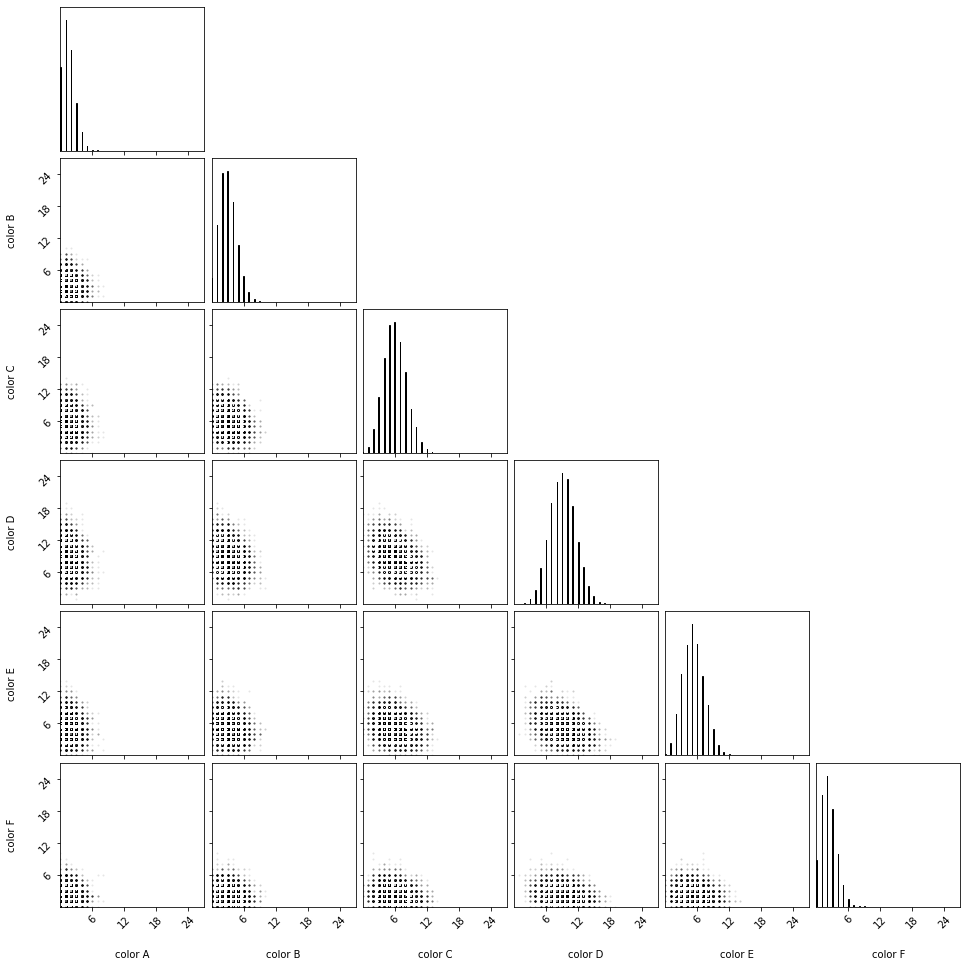

In [4]:
#------------------------------------------------
#corner plot (problem 1.3)
#------------------------------------------------

# The multinomial distribution is a multivariat distribution. The true nature can only be appreciated looking
# at all dimensions. One way to do this are 2D-histograms showing the 2D-projections of the distribution
#of the random variable. A full set of those pariwise histograms is called a 'corner plot'. 
#It is widely used for depticting the posterior distributions of parameters in Bayesian statistics.

figure = corner.corner(mn, plot_contours = False, bins = 250, range = [(0,27),(0,27),(0,27),(0,27),(0,27),(0,27)],\
                       labels = ['color A','color B','color C','color D','color E','color F'])

# Problem 2: Monte Carlo Simulations of random variables based on uniform random numbers on [0,1[

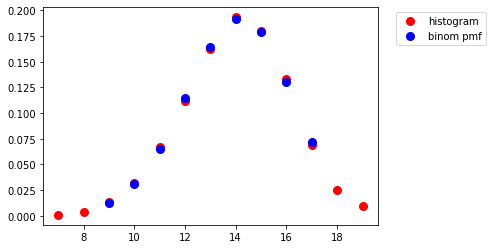

In [5]:
#--------------------------------------------------
#exercise 2.1: Sampling from binomial distributions
#--------------------------------------------------

n = 10000
p = 0.7

#calculated the sum of a Bernoulli sequence for 20 coin tosses
x = np.zeros(n)
for i in range(n):
    u = np.random.random(size = 20)
    x[i]=np.count_nonzero(u<p)

#make histogram   
hist, bin_edges = np.histogram(x, bins = range(7,21))
plt.plot(bin_edges[:-1],hist/n, 'bo', ms=8, color = 'red', label='histogram')

#plot pmf from scipy.stats
xxx = np.arange(sp.stats.binom.ppf(0.01, 20, p),
              sp.stats.binom.ppf(0.99, 20, p))
plt.plot(xxx, sp.stats.binom.pmf(xxx, 20, p), 'bo', ms=8, label='binom pmf')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

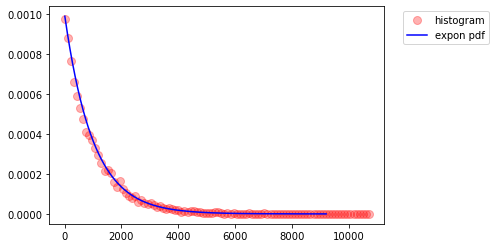

In [6]:
#-----------------------------------------------------
#exercise 2.2: Sampling from exponential distributions
#-----------------------------------------------------


n = 10000
c = 0.001

u = np.random.random(size = n)

#use the inverse CDF
x = -np.log(u)/c

hist, bin_edges = np.histogram(x, bins = 100, density = True)
plt.plot(bin_edges[:-1],hist, 'bo', ms=8, color = 'red', label='histogram', alpha = 0.3)

xxx = np.arange(sp.stats.expon.ppf(0.01, scale = 1/c),
              sp.stats.expon.ppf(0.9999, scale = 1/c))
plt.plot(xxx, sp.stats.expon.pdf(xxx, scale = 1/c), label='expon pdf', alpha = 1, color = 'blue')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

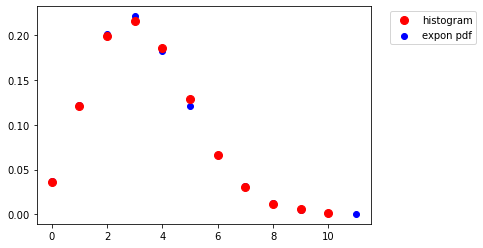

In [7]:
#-----------------------------------------------------
#exercise 2.3: Sampling from Poisson distributions
#-----------------------------------------------------

#Pseudo code implementation
@jit(nopython=True)
def poisson_algo(lam):
    v = 1
    k = -1

    while(v > np.exp(-lam)):
        v = v*np.random.random()
        k += 1
    return (k)

# random numbers generator
@jit(nopython=True)
def make_poisson_rv(lam,n):
    x = np.zeros(n)
    for i in range(n):
        x[i] = poisson_algo(lam)
    return x

n = 10000
lam = 3.3

xx = make_poisson_rv(lam,1) # dummy call to make numba compile the function
x = make_poisson_rv(lam,n) # generate random numbers

hist, bin_edges = np.histogram(x, bins = range(0,12), density = True)
plt.plot(bin_edges[:-1],hist, 'bo', ms=8, color = 'red', label='histogram', alpha = 1.0)

xxx = np.arange(sp.stats.poisson.ppf(0.01, lam),
              sp.stats.poisson.ppf(0.9999, lam))
plt.scatter(xxx, sp.stats.poisson.pmf(xxx, lam), label='expon pdf', alpha = 1, color = 'blue')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

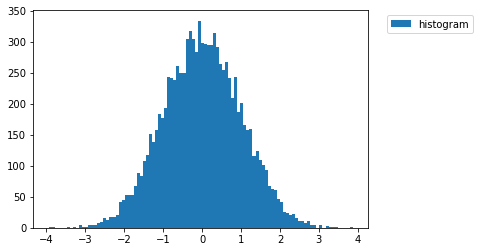

In [8]:
#-----------------------------------------------------
#exercise 2.3: Sampling from normal distributions
#-----------------------------------------------------

#Pseudo code implementation
@jit(nopython=True)
def normal_algo():
    w = 2
    while(w>1):
        u = 2.*np.random.random()-1.
        v = 2.*np.random.random()-1.
        w = u**2. + v**2.
    a = np.sqrt(-2.*np.log(w)/w)
    return a*u, a*v

# normal random number generator (not only standard)
@jit(nopython=True)
def make_normal_rv(mu,sig,n):
    x = np.zeros(n)
    for i in range(n):
        xx, yy = normal_algo()
        x[i] = mu + xx * sig
    return x

#parameters
mu = 0.
sig = 1.
n = 10000

#draw samples
x = make_normal_rv(mu,sig,1)
x = make_normal_rv(mu,sig,n)

plt.hist(x,bins=100, label = 'histogram')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Problem 3: Normality  and central limit theorem

In [9]:
#------------------------------------------------------------
#exercise 3.1: sums of uniformly distributed random variables
#------------------------------------------------------------
#generate 10k samples of the sum of 100k independent and uniformly and identically distributed random variables;
#time it

x = np.zeros(10000)
n = 100000
start_time = time.time()
for i in range(0,x.size):
    x[i] = np.sum(np.random.uniform(0.0,1.0,n))
print(time.time()-start_time)

6.187954902648926


In [10]:
# same as above in form of a function; with the use of numba to speed it up

@jit(nopython=True)
def sum_of_ran_var(x,n):
    for i in range(0,x.size):
        x[i] = np.sum(np.random.uniform(0.0,1.0,n))


In [11]:
# generate samples

x = np.zeros(10000)
n = 100000
start_time = time.time()
sum_of_ran_var(x,n)
print(time.time()-start_time)


5.440250873565674


In [12]:
# define normal PDF
def Normal(x, mu=0., sig=1.):
    return 1./sig/np.sqrt(2.*pi)*np.exp(-(x-mu)*(x-mu)/sig/sig/2.)

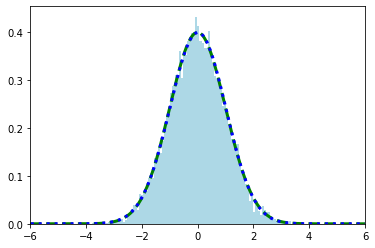

In [13]:
#generate binomial PMF and plot histogram, PMF and PDF together
p = 0.7
q = 1-0.7
nn = 1000

xx = np.linspace(-6.,6.,1000)
xxx = np.array(range(nn))

plt.plot(xx, Normal(xx), '--', lw = 3.0, color = 'green')
plt.plot((xxx-nn*p)/np.sqrt(nn*p*q),sp.stats.binom.pmf(xxx,nn,p)*np.sqrt(nn*p*q), ':', lw = 3.0, color = 'blue')
plt.hist((x - n*0.5)/np.sqrt(n/12.), bins = 100, density = True, color = 'lightblue', alpha = 1.0)
plt.xlim([-6., 6.])
plt.show()

In [14]:
#----------------------------------------------------------
#exercise 3.2: sums of Cauchy distributed random variables
#----------------------------------------------------------

x = np.zeros(10000)
n = 100000
start_time = time.time()
for i in range(0,x.size):
    x[i] = np.sum(np.random.standard_cauchy(n))
print(time.time()-start_time)

47.02686095237732


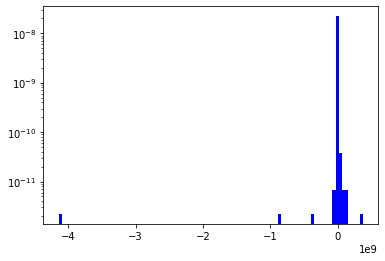

In [15]:
#plot histogram

plt.hist(x, bins = 100, density = True, color = 'blue', alpha = 1.0)
plt.yscale('log')
plt.show()

In [82]:
#----------------------------------------------------------
#exercise 3.3
#----------------------------------------------------------

#simulated distribution of spectral indexes
def sp_index_dist(freq_ratio = 10, sp_index = -0.6, s_n = 10, ref_flux = 1.0):

    x1 = ref_flux + ref_flux/s_n * np.random.standard_normal(size=10000)
    x2 = freq_ratio**(sp_index) * (ref_flux + ref_flux/s_n * np.random.standard_normal(size=10000))
    ratio = x2/x1
    index = np.log(ratio[np.where(ratio > 0)])/np.log(freq_ratio)
    return ratio, index

#formal error propergation
def sp_index_error_prop(freq_ratio = 10, sp_index = -0.6, s_n = 10, ref_flux = 1.0):

    x1 = uncertainties.ufloat(ref_flux, 1./s_n)
    x2 = freq_ratio**(sp_index) * uncertainties.ufloat(ref_flux, 1./s_n)
    return x2/x1, umath.log(x2/x1)/umath.log(freq_ratio)

-0.60+/-0.06


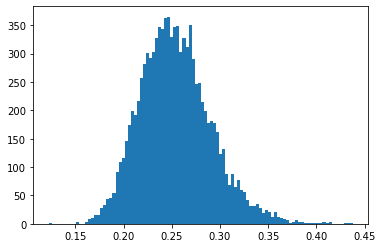

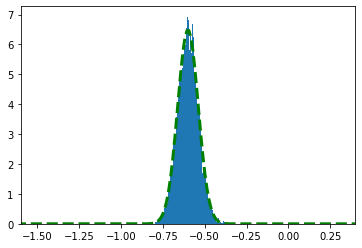

In [17]:
#execute functions for freq_ratio = 10, sp_index = -0.6, s_n = 10, ref_flux = 1.0
ratio, index = sp_index_dist()
ratio_prop, index_prop = sp_index_error_prop()
print(index_prop)
#print(np.min(index), np.max(index))

#histogram of flux density ratios
plt.hist(ratio, bins = 100)
plt.show()

#histogram of spectral indexes
plt.hist(index, bins = 100, density = True)
plt.plot(xx, Normal(xx, index_prop.n, index_prop.s), '--', lw = 3.0, color = 'green')
plt.xlim([-1.6,0.4])
plt.show()

-0.60+/-0.04
-0.7480747684659649 -0.44072642417080865


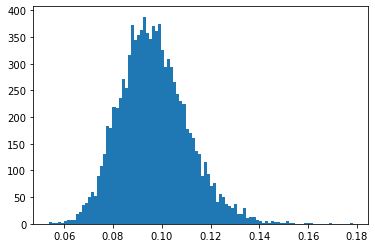

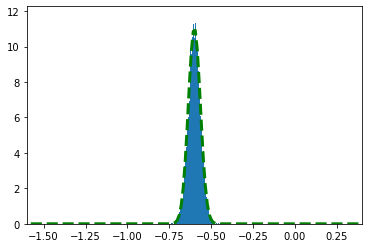

In [18]:
#change to freq_ratio = 50

ratio, index = sp_index_dist(freq_ratio = 50)
ratio_prop, index_prop = sp_index_error_prop(freq_ratio = 50)
print(index_prop)
print(np.min(index), np.max(index))

plt.hist(ratio, bins = 100)
plt.show()

plt.hist(index, bins = 100, density = True)
plt.plot(xx, Normal(xx, index_prop.n, index_prop.s), '--', lw = 3.0, color = 'green')
plt.xlim([-1.6,0.4])
plt.show()

-0.6+/-0.7
-0.5927728974487934 0.3837921192749714
-2.8692772545645053 1.214935072622664


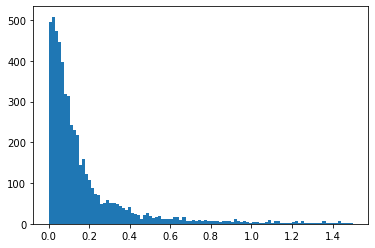

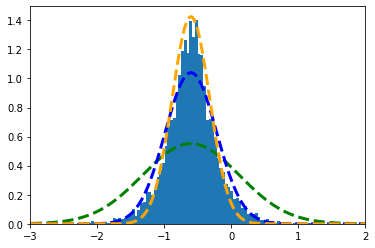

In [19]:
#change to s_n = 0.5

ratio, index = sp_index_dist(freq_ratio = 50,s_n = 0.5)
index = index[~np.isnan(index)]
ratio_prop, index_prop = sp_index_error_prop(freq_ratio = 50,s_n = 0.5)
print(index_prop)
print(np.mean(index), np.std(index))
print(np.min(index), np.max(index))

plt.hist(ratio, bins = 100, range = (0,1.5))
plt.show()

plt.hist(index, bins = 100, density = True)

#plot normal PDF with propagated values
plt.plot(xx, Normal(xx, index_prop.n, index_prop.s), '--', lw = 3.0, color = 'green')

#plot normal PDF with variance from spectral index distribution
plt.plot(xx, Normal(xx, index_prop.n, np.std(index)), '--', lw = 3.0, color = 'blue')

#plot normal PDF that describes the peak rather well, but fails to describe the tails
plt.plot(xx, Normal(xx, index_prop.n, 0.28), '--', lw = 3.0, color = 'orange')

plt.xlim([-3.0,2.0])
plt.show()

# Problem 4: Empirical data

In [20]:
#----------------------------------------------------------
#exercise 4.1: Machine readable tables and Pandas
#----------------------------------------------------------

data = Table.read("table_3_witzel18.txt", format="ascii.cds")

In [21]:
print(type(data))
print(data)
print(data[1])
print(data[1][3])
print(data['Obs'])

<class 'astropy.table.table.Table'>
    Obs           HMJD       Flux    RefFlux 
                   d          Jy        Jy   
------------ ------------- -------- ---------
Spitzer/IRAC  56636.180292 0.002614 -0.000366
Spitzer/IRAC 56636.1803889 0.004365  0.000927
Spitzer/IRAC 56636.1804861   0.0042 -0.000582
Spitzer/IRAC 56636.1805834 0.002945 -0.000327
Spitzer/IRAC 56636.1806807 0.002654  0.000117
Spitzer/IRAC 56636.1807779 0.003472 -0.001563
Spitzer/IRAC  56636.180875 0.003898 -0.001031
Spitzer/IRAC 56636.1809719 0.002565 -0.000806
Spitzer/IRAC 56636.1810694 0.003251 -0.001304
Spitzer/IRAC 56636.1811665 0.003006 -0.001488
         ...           ...      ...       ...
  Keck/NIRC2 56493.3973268  4.5e-05        --
  Keck/NIRC2 56493.3979267  3.9e-05        --
  Keck/NIRC2 56493.3985167  4.6e-05        --
  Keck/NIRC2 56493.3991467  5.6e-05        --
  Keck/NIRC2 56493.3998466  3.8e-05        --
  Keck/NIRC2 56493.4004266  6.7e-05        --
  Keck/NIRC2 56493.4010166  6.9e-05        -

In [22]:
df = data.to_pandas()

In [23]:
print(type(df))
display(df)


<class 'pandas.core.frame.DataFrame'>


Obs          HMJD      Flux   RefFlux
0      Spitzer/IRAC  56636.180292  0.002614 -0.000366
1      Spitzer/IRAC  56636.180389  0.004365  0.000927
2      Spitzer/IRAC  56636.180486  0.004200 -0.000582
3      Spitzer/IRAC  56636.180583  0.002945 -0.000327
4      Spitzer/IRAC  56636.180681  0.002654  0.000117
...             ...           ...       ...       ...
94923    Keck/NIRC2  56493.400427  0.000067       NaN
94924    Keck/NIRC2  56493.401017  0.000069       NaN
94925    Keck/NIRC2  56493.401616  0.000083       NaN
94926    Keck/NIRC2  56493.402247  0.000078       NaN
94927    Keck/NIRC2  56493.402836  0.000085       NaN

[94928 rows x 4 columns]

In [24]:
print(df['Obs'].unique())

df_Spitzer=df.loc[df['Obs'] == 'Spitzer/IRAC', ['Obs','Flux']]
display(df_Spitzer)
print('Spitzer mean: ', "{:10.6f}".format(df_Spitzer['Flux'].mean()), 'Spitzer std: ', "{:10.6f}".format(df_Spitzer['Flux'].std()))

df_Keck=df.loc[df['Obs'] == 'Keck/NIRC2', ['Obs','Flux']]
display(df_Keck)
print('Keck mean: ', "{:10.6f}".format(df_Keck['Flux'].mean()), 'Keck std: ', "{:10.6f}".format(df_Keck['Flux'].std()))

df_VLT=df.loc[df['Obs'] == 'VLT/NaCo', ['Obs','Flux']]
display(df_VLT)
print('VLT mean: ', "{:10.6f}".format(df_VLT['Flux'].mean()), 'VLT std: ', "{:10.6f}".format(df_VLT['Flux'].std()))

['Spitzer/IRAC' 'VLT/NaCo' 'Keck/NIRC2']


Obs      Flux
0      Spitzer/IRAC  0.002614
1      Spitzer/IRAC  0.004365
2      Spitzer/IRAC  0.004200
3      Spitzer/IRAC  0.002945
4      Spitzer/IRAC  0.002654
...             ...       ...
81123  Spitzer/IRAC  0.001102
81124  Spitzer/IRAC  0.000540
81125  Spitzer/IRAC  0.000605
81126  Spitzer/IRAC  0.001524
81127  Spitzer/IRAC  0.001144

[81128 rows x 2 columns]

Spitzer mean:    0.000445 Spitzer std:    0.001364


Obs      Flux
91771  Keck/NIRC2  0.000409
91772  Keck/NIRC2  0.000531
91773  Keck/NIRC2  0.000473
91774  Keck/NIRC2  0.000643
91775  Keck/NIRC2  0.000563
...           ...       ...
94923  Keck/NIRC2  0.000067
94924  Keck/NIRC2  0.000069
94925  Keck/NIRC2  0.000083
94926  Keck/NIRC2  0.000078
94927  Keck/NIRC2  0.000085

[3157 rows x 2 columns]

Keck mean:    0.000159 Keck std:    0.000201


Obs      Flux
81128  VLT/NaCo  0.000174
81129  VLT/NaCo  0.000158
81130  VLT/NaCo  0.000084
81131  VLT/NaCo  0.000167
81132  VLT/NaCo  0.000163
...         ...       ...
91766  VLT/NaCo  0.000093
91767  VLT/NaCo  0.000095
91768  VLT/NaCo  0.000189
91769  VLT/NaCo  0.000211
91770  VLT/NaCo  0.000239

[10643 rows x 2 columns]

VLT mean:    0.000216 VLT std:    0.000225


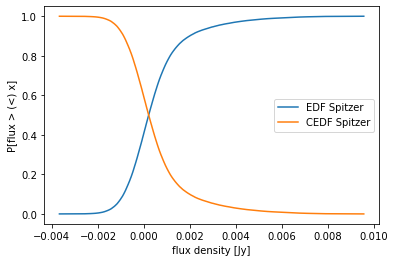

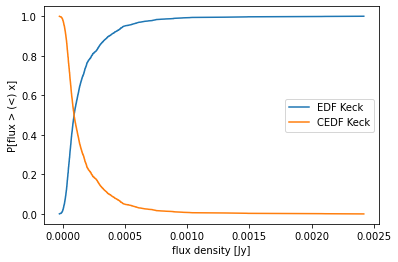

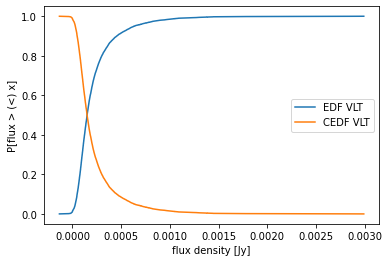

In [25]:
def edf(x):
    n = len(x)
    y = np.linspace(1,n,n)/n
    x = np.sort(x)
    return (x,y)
    
def cedf(x):
    n = len(x)
    y = 1. - np.linspace(1,n,n)/n
    x = np.sort(x)
    return (x,y)

x_cdf,y_cdf = edf(df_Spitzer['Flux'])
x_ccdf,y_ccdf = cedf(df_Spitzer['Flux'])

plt.plot(x_cdf,y_cdf, label = 'EDF Spitzer')
plt.plot(x_ccdf,y_ccdf, label = 'CEDF Spitzer')
plt.xlabel('flux density [Jy]')
plt.ylabel('P[flux > (<) x]')
plt.legend()
plt.show()

x_cdf,y_cdf = edf(df_Keck['Flux'])
x_ccdf,y_ccdf = cedf(df_Keck['Flux'])

plt.plot(x_cdf,y_cdf, label = 'EDF Keck')
plt.plot(x_ccdf,y_ccdf, label = 'CEDF Keck')
plt.xlabel('flux density [Jy]')
plt.ylabel('P[flux > (<) x]')
plt.legend()
plt.show()

x_cdf,y_cdf = edf(df_VLT['Flux'])
x_ccdf,y_ccdf = cedf(df_VLT['Flux'])

plt.plot(x_cdf,y_cdf, label = 'EDF VLT')
plt.plot(x_ccdf,y_ccdf, label = 'CEDF VLT')
plt.xlabel('flux density [Jy]')
plt.ylabel('P[flux > (<) x]')
plt.legend()
plt.show()

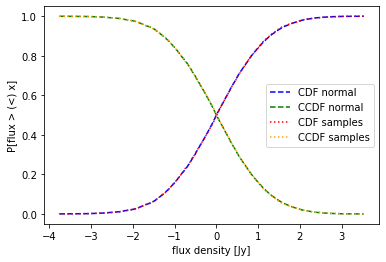

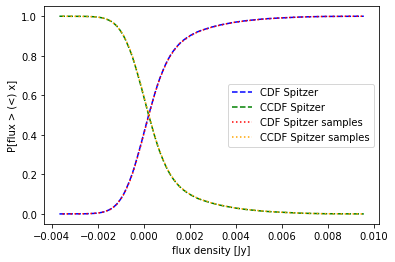

In [26]:
#sampling from an emirical distribution
def empi_sampler(x):
    n = len(x)
    ind = np.random.randint(0, high = n)
    return x[ind]    

#example i.i.d. data
n = 10000
x = np.random.normal(size = n)
samples = np.zeros(n)
for i in range(n):
    samples[i] = empi_sampler(x)
    
x_edf,y_edf = edf(x)
x_cedf,y_cedf = cedf(x)
x_edf_samp,y_edf_samp = edf(samples)
x_cedf_samp,y_cedf_samp = cedf(samples)

plt.plot(x_edf,y_edf,'--', label = 'CDF normal', color = 'blue')
plt.plot(x_cedf,y_cedf,'--', label = 'CCDF normal', color = 'green')
plt.plot(x_edf_samp,y_edf_samp,':', label = 'CDF samples', color = 'red' )
plt.plot(x_cedf_samp,y_cedf_samp,':', label = 'CCDF samples', color = 'orange')
plt.xlabel('flux density [Jy]')
plt.ylabel('P[flux > (<) x]')
plt.legend()
plt.show()
    

# example correlated light curve
n = df_Spitzer['Flux'].size
samples_Spitzer = np.zeros(n)
for i in range(n):
    samples_Spitzer[i] = empi_sampler(df_Spitzer['Flux'])

x_edf,y_edf = edf(df_Spitzer['Flux'])
x_cedf,y_cedf = cedf(df_Spitzer['Flux'])    
x_edf_samp,y_edf_samp = edf(samples_Spitzer)
x_cedf_samp,y_cedf_samp = cedf(samples_Spitzer)

plt.plot(x_edf,y_edf,'--', label = 'CDF Spitzer', color = 'blue')
plt.plot(x_cedf,y_cedf,'--', label = 'CCDF Spitzer', color = 'green')
plt.plot(x_edf_samp,y_edf_samp,':', label = 'CDF Spitzer samples', color = 'red' )
plt.plot(x_cedf_samp,y_cedf_samp,':', label = 'CCDF Spitzer samples', color = 'orange')
plt.xlabel('flux density [Jy]')
plt.ylabel('P[flux > (<) x]')
plt.legend()
plt.show()       



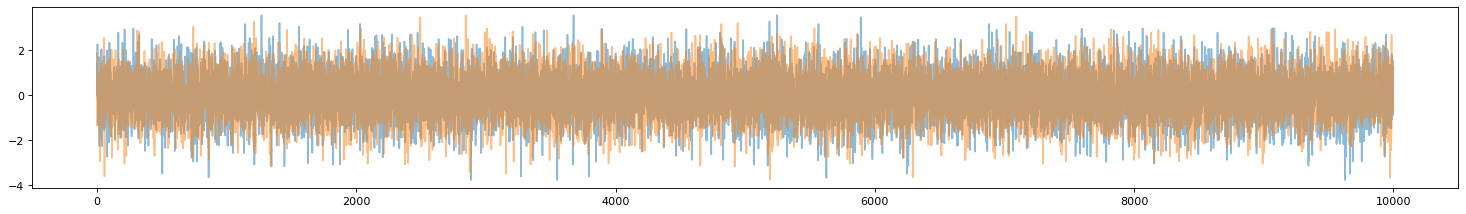

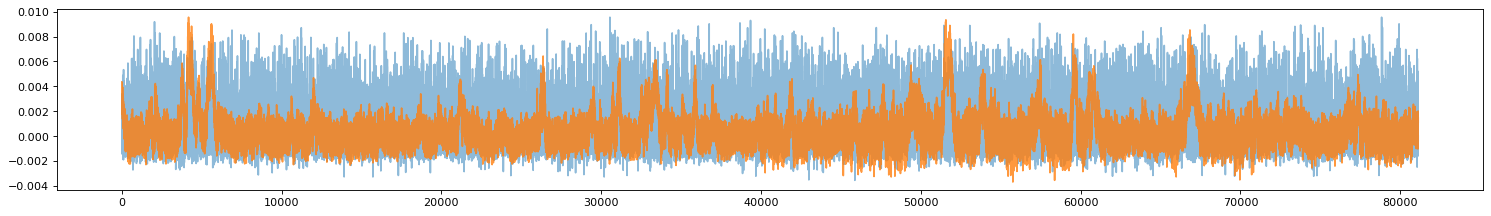

In [27]:
plt.figure(figsize=(23, 3), dpi=80)
plt.plot(samples, alpha = 0.5)
plt.plot(x, alpha = 0.5)
plt.show()

plt.figure(figsize=(23, 3), dpi=80)
plt.plot(samples_Spitzer, alpha = 0.5)
plt.plot(df_Spitzer['Flux'], alpha = 0.8)
plt.show()

0.044837151387197065


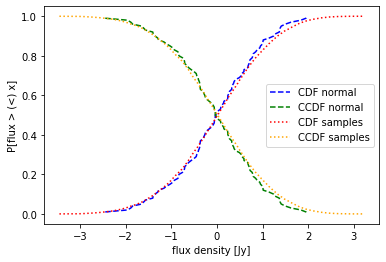

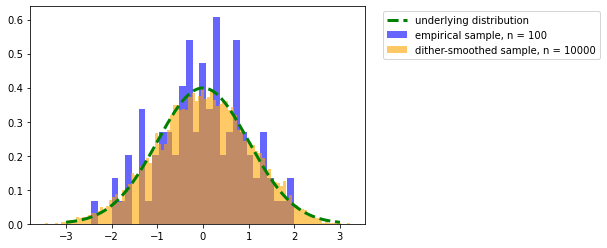

In [28]:
#convolution ("dither") sampler, Gaussian kernel
def empi_sampler_smooth(x, width):
    n = len(x)
    ind = np.random.randint(0, high = n)
    return x[ind] + width * np.random.normal()

#example i.i.d. data
n = 10000
x = np.random.normal(size = 100)
diff = np.diff(np.sort(x)).mean()
print(diff)
samples = np.zeros(n)
for i in range(n):
    samples[i] = empi_sampler_smooth(x, 10.*diff)

x_edf,y_edf = edf(x)
x_cedf,y_cedf = cedf(x)
x_edf_samp,y_edf_samp = edf(samples)
x_cedf_samp,y_cedf_samp = cedf(samples)

plt.plot(x_edf,y_edf,'--', label = 'CDF normal', color = 'blue')
plt.plot(x_cedf,y_cedf,'--', label = 'CCDF normal', color = 'green')
plt.plot(x_edf_samp,y_edf_samp,':', label = 'CDF samples', color = 'red' )
plt.plot(x_cedf_samp,y_cedf_samp,':', label = 'CCDF samples', color = 'orange')
plt.xlabel('flux density [Jy]')
plt.ylabel('P[flux > (<) x]')
plt.legend()
plt.show()

xx = np.linspace(-3.,3.,1000)

plt.hist(x, bins=30, alpha = 0.6, color = 'blue', density = True, label = 'empirical sample, n = 100')
plt.hist(samples, bins=100, alpha = 0.6, color = 'orange', density = True, label = 'dither-smoothed sample, n = 10000')
plt.plot(xx, Normal(xx), '--', lw = 3.0, color = 'green', label = 'underlying distribution')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Problem 5: Markov chains, ergodic theorem and asymptotic stationarity

In [29]:
#------------------------------------------------------------------
#exercise 5.1: Multiplication of the transition matrix with itsself
#------------------------------------------------------------------

#transition matrix
p = np.array([[1/2,1/2,0],
              [1/3,1/3,1/3],
              [1,0,0]])

# matrix power function
def mat_power(mat, n):
    mat_tmp = mat
    for i in range(n-1): 
        mat_tmp = np.matmul(mat_tmp,mat)
    return mat_tmp

#Take the transition matrix to the power of 1,2,8,20,100,and 200
alpha = mat_power(p, 1)
print(alpha)
print('')
alpha = mat_power(p, 2)
print(alpha)
print('')
alpha = mat_power(p, 8)
print(alpha)
print('')
alpha = mat_power(p, 20)
print(alpha)
print('')
alpha = mat_power(p, 100)
print(alpha)
print('')
alpha = mat_power(p, 200)
print(alpha)

[[0.5        0.5        0.        ]
 [0.33333333 0.33333333 0.33333333]
 [1.         0.         0.        ]]

[[0.41666667 0.41666667 0.16666667]
 [0.61111111 0.27777778 0.11111111]
 [0.5        0.5        0.        ]]

[[0.5000518  0.37520183 0.12474637]
 [0.4996273  0.37498452 0.12538818]
 [0.50091092 0.37423911 0.12484997]]

[[0.49999999 0.375      0.12500001]
 [0.50000001 0.37499999 0.12499999]
 [0.49999999 0.37500002 0.12499999]]

[[0.5   0.375 0.125]
 [0.5   0.375 0.125]
 [0.5   0.375 0.125]]

[[0.5   0.375 0.125]
 [0.5   0.375 0.125]
 [0.5   0.375 0.125]]


In [30]:
#------------------------------------------------------------------
#exercise 5.2: MC walker on three outcomes
#------------------------------------------------------------------

p0 = 1 #starting point of walker

# Markov chain implementation
def walker(p, n):
    chain = np.zeros(n+1)
    chain[0] = copy.deepcopy(p)
    print('starting point: ', p)
    for i in range(n):
        u = np.random.random()
        if p == 1:
            if 0 < u <= 0.5:
                p = 1
            else:
                p = 2
        elif p == 2:
            if 0<u<=1./3.:
                p = 1
            if 1./3.<u<=2./3.:
                p = 2
            if 2./3.<u<=1.:
                p = 3
        else:
            p = 1
        chain[i+1] = p
    return chain

# Call walker
chain = walker(p0,1000000)

#Evaluation function for Markov chain
def evaluate_chain(chain): 
    sum1 = ((chain == 1).sum())
    sum2 = ((chain == 2).sum())
    sum3 = ((chain == 3).sum())

    sum_total = sum1 + sum2 + sum3

    return(sum1/sum_total,sum2/sum_total,sum3/sum_total)

print(evaluate_chain(chain[100::100]))
print(evaluate_chain(chain[:20]))
print(evaluate_chain(chain[2000:2020]))

# Evaluate Markov chain as a function of steps for a given starting point
nn = 10000
start_ind = 2000
res = np.zeros((nn,3))
for i in range(nn):
    ii = int(start_ind + i + 1)
    res[i,:] = evaluate_chain(chain[start_ind:ii])

# plot results
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(range(1,nn+1), res[:,0], color = 'blue', label = 'state 1')
plt.plot(range(1,nn+1), res[:,1], color = 'red', label = 'state 2')
plt.plot(range(1,nn+1), res[:,2], color = 'green', label = 'state 3')
plt.axhline(0.5, color = 'blue', linestyle = '--')
plt.axhline(0.375, color = 'red', linestyle = '--')
plt.axhline(0.125, color = 'green', linestyle = '--')
plt.xscale('log')
plt.xlabel('steps since step 2000')
plt.ylabel('frequency of occurence')
plt.legend()
plt.show()

starting point:  1
(0.5017, 0.3717, 0.1266)
(0.55, 0.4, 0.05)
(0.5, 0.35, 0.15)


# Problem 6: Linear Regression, chi^2 and t-Student tests

In [32]:
#------------------------------------------------------------------
#exercise 6.1
#------------------------------------------------------------------


#function for calculating linear regression coefficients
def linear_regression(x,y,y_err):
    w = 1/y_err
    delta = w.sum() * np.sum(w*x**2.) - (np.sum(w*x))**2.
    m  = ((w.sum() * np.sum(w*x*y)) - (np.sum(w*x)*np.sum(w*y)))/delta
    b  = ((np.sum(w*x**2.) * np.sum(w*y)) - (np.sum(w*x)*np.sum(w*x*y)))/delta
    sigma_y = np.sqrt(1./(n-2.) * np.sum((y- m * x - b)**2.))
    m_err = np.sqrt(w.sum()/delta * sigma_y**2.)
    b_err = np.sqrt(np.sum(w*x**2.)/delta * sigma_y**2.)
    return (m, b, m_err, b_err)

#make mock data
n = 26
a = 3.5
b = 5.2

x = 24*np.random.random(size = n)-12.
y_error = 12.5* np.random.random(size = n)
y = a+ x*b + y_error * np.random.normal(size = n)

#execute regression
regr = linear_regression(x,y,y_error)
print(regr)
xx = np.linspace(-12,12,100)

#plot results
for i in range(1000):
    plt.plot(xx, (regr[0]+ regr[2] * np.random.normal()) * xx + regr[1] + regr[3] * np.random.normal(), \
             color = 'skyblue', alpha = 0.1, zorder = 1)
plt.errorbar(x,y, yerr = y_error, fmt=".", color = 'blue')
plt.plot(xx, regr[0] * xx + regr[1])
plt.plot();

(5.093025969908472, 3.4627759502713045, 0.2865373625155744, 2.052055721920612)


In [33]:
#------------------------------------------------------------------
#exercise 6.2
#------------------------------------------------------------------


#function for chi^2 computation
def chi2(param,x,y,y_err):
    return np.sum(((y - param[0] - param[1]*x)/y_err)**2.)

#running chi^2 minimization
p0 = np.array([3.2, 4.8])
bounds = np.array([(0.0,10.0),(0.0,10.0)])
resid = lambda *args: residual(*args)
soln = optimize.minimize(chi2, p0, args=(x,y,y_error), bounds = bounds)
p_min_chisq = soln.x

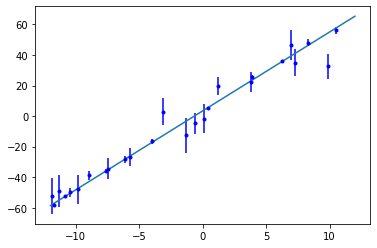

In [34]:
#ploting chi^2 minimization results
plt.errorbar(x,y, yerr = y_error, fmt=".", color = 'blue')
plt.plot(xx, p_min_chisq[1] * xx + p_min_chisq[0])
plt.plot();

In [36]:
#print out diagnostics
#degrees of freedom
dof = 2

#find chi^2 values for both fits
chi2_1 = chi2([regr[1],regr[0]],x,y,y_error)
chi2_2 = chi2(p_min_chisq,x,y,y_error)

#find p-values with scipy cdf
p_1 = 1.-sp.stats.chi2.cdf(chi2_1/(n-dof),dof)
p_2 = 1.-sp.stats.chi2.cdf(chi2_2/(n-dof),dof)

#print chi^2 values
print("chi^2 values")
print(chi2_1)
print(chi2_2)
print('###################')
#print reduced chi^2 values and p-values
print("reduced chi^2 values")
print(chi2_1/(n-dof))
print(chi2_2/(n-dof))
print('###################')
print("p values")
print(p_1)
print(p_2)


chi^2 values
25.358343307688717
23.110062451009792
###################
reduced chi^2 values
1.0565976378203632
0.9629192687920747
###################
p values
0.5896071455217491
0.6178808531322507


In [37]:
#------------------------------------------------------------------
#exercise 6.3
#------------------------------------------------------------------


#Student's t-tests - one sided test for expectation value
#make mock data
x = np.random.normal(loc = 8.97, scale = 2.4, size = 100)

mu1 = 8.2
mu2 = 8.90

#execute t-test
t_value,p_value=sp.stats.ttest_1samp(x,mu1)

#evaluate results
# Since alternative hypothesis is one tailed, We need to divide the p value by 2.
one_tailed_p_value=float("{:.6f}".format(p_value/2)) 
print('Test statistic is %f'%float("{:.6f}".format(t_value)))
print('p-value for one tailed test is %f'%one_tailed_p_value)

t_value,p_value=sp.stats.ttest_1samp(x,mu2)

# Since alternative hypothesis is one tailed, We need to divide the p value by 2.
one_tailed_p_value=float("{:.6f}".format(p_value/2)) 
print('Test statistic is %f'%float("{:.6f}".format(t_value)))
print('p-value for one tailed test is %f'%one_tailed_p_value)

Test statistic is 4.570666
p-value for one tailed test is 0.000007
Test statistic is 1.748197
p-value for one tailed test is 0.041765


In [38]:
#------------------------------------------------------------------
#exercise 6.4
#------------------------------------------------------------------

#Student's t-tests - two sided test for comparing means of two distributions (Gaussian and with equal variance)
#make mock data
x1 = np.random.normal(loc = 8.97, scale = 2.4, size = 100)
x2 = np.random.normal(loc = 7.8, scale = 2.4, size = 100)
x3 = np.random.normal(loc = 8.97, scale = 2.4, size = 100)

#execute t-test
t_value,p_value=sp.stats.ttest_ind(x1,x2)

#evaluate results
one_tailed_p_value=float("{:.6f}".format(p_value)) 
print('Test statistic is %f'%float("{:.6f}".format(t_value)))
print('p-value for two tailed test is %f'%one_tailed_p_value)

t_value,p_value=sp.stats.ttest_ind(x1,x3)

one_tailed_p_value=float("{:.6f}".format(p_value)) 
print('Test statistic is %f'%float("{:.6f}".format(t_value)))
print('p-value for two tailed test is %f'%one_tailed_p_value)

Test statistic is 2.184319
p-value for two tailed test is 0.030113
Test statistic is -0.350599
p-value for two tailed test is 0.726262


In [39]:
#------------------------------------------------------------------
#exercise 6.5
#------------------------------------------------------------------

#Student's t-tests - one sided test for testing if two distributions stayed the same or
#if a difference in the mean values is significant
#make mock data
np.random.seed(43)
x1 = np.random.normal(loc = 8.97, scale = 2.4, size = 100)
np.random.seed(43)
x2 = np.random.normal(loc = 8.97, scale = 2.4, size = 100) + \
        np.random.normal(scale = 0.2, size = 100)
np.random.seed(43)
x3 = np.random.normal(loc = 8.9, scale = 2.4, size = 100) + \
        np.random.normal(scale = 0.2, size = 100)

#execute t-test
t_value,p_value=sp.stats.ttest_rel(x1,x2)

#evaluate results
# Since alternative hypothesis is one tailed, We need to divide the p value by 2.
one_tailed_p_value=float("{:.6f}".format(p_value/2)) 
print('Test statistic is %f'%float("{:.6f}".format(t_value)))
print('p-value for one tailed test is %f'%one_tailed_p_value)

t_value,p_value=sp.stats.ttest_rel(x1,x3)

# Since alternative hypothesis is one tailed, We need to divide the p value by 2.
one_tailed_p_value=float("{:.6f}".format(p_value/2)) 
print('Test statistic is %f'%float("{:.6f}".format(t_value)))
print('p-value for one tailed test is %f'%one_tailed_p_value)

Test statistic is -0.138594
p-value for one tailed test is 0.445026
Test statistic is 3.190924
p-value for one tailed test is 0.000950


# Problem 7: MCMC sampling of a 5-dim normal distribution

In [40]:
# define the log-probability of a multidimensional Gaussian  
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))


In [41]:
#set dimensions and draw random parameters for 5D mean and 5x5 covariance matrix; 
# use a seed to make results reproducable 
ndim = 5

np.random.seed(45)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
print(cov)
cov = np.triu(cov)
print(cov)
cov += cov.T - np.diag(cov.diagonal())
print(cov)
cov = np.dot(cov, cov)
print(cov)

[[ 0.02719203  0.451478    0.33667555  0.38404929 -0.12739168]
 [-0.35618205 -0.15010242 -0.49072168  0.02964925 -0.11829448]
 [ 0.21733279 -0.47600332 -0.173068    0.05946911  0.21031266]
 [-0.00969968  0.3875391   0.27304521  0.0214477   0.25724184]
 [ 0.11201748 -0.31887343  0.42545921 -0.42314954  0.27510392]]
[[ 0.02719203  0.451478    0.33667555  0.38404929 -0.12739168]
 [ 0.         -0.15010242 -0.49072168  0.02964925 -0.11829448]
 [ 0.          0.         -0.173068    0.05946911  0.21031266]
 [ 0.          0.          0.          0.0214477   0.25724184]
 [ 0.          0.          0.          0.          0.27510392]]
[[ 0.02719203  0.451478    0.33667555  0.38404929 -0.12739168]
 [ 0.451478   -0.15010242 -0.49072168  0.02964925 -0.11829448]
 [ 0.33667555 -0.49072168 -0.173068    0.05946911  0.21031266]
 [ 0.38404929  0.02964925  0.05946911  0.0214477   0.25724184]
 [-0.12739168 -0.11829448  0.21031266  0.25724184  0.27510392]]
[[ 0.48164471 -0.19424882 -0.27461593  0.01931736  0

In [42]:
# set up parameters for emcee
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [43]:
# set up emcee sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [44]:
# evaluate probability at the randomly chosen start point
log_prob(p0[0], means, cov)

-1.1756305077234444

In [45]:
# burn in sampler with 100 steps
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [46]:
# continue sampler from burned-in state for 10k steps
sampler.run_mcmc(state, 10000);

In [47]:
# create chain and plot the distributions for one of the 5 dimensions
samples = sampler.get_chain(flat=True)

plt.figure(figsize=(8, 8), dpi=80)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [48]:
# print diagnostics
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.551
Mean autocorrelation time: 56.235 steps


# Problem 8: Fitting realistic orbit data of the Galactic Center star S(0)-2

In [49]:
#P, T, a, e, i, om, Om

In [50]:
#------------------------------------------------
#exercise 8.1
#------------------------------------------------

# setting up constants and orbital elements from Do et al 2019.
con = constants()
# The orbital elements of S2 from Do et al. 2019
D = 7959 # Distance to Sgr A* [pc]
M = 3.975e6 # Sgr A* mass [Msun]
P = 16.042 # S2 period [yr]
T0 = 2018.3763 # the time of the closest approach [yrr]
e = 0.8858 # S2 orbit Eccentricity  
inc = 133.82 # S2 orbit inclination [deg]
om = 66.11 # S2 orbit argument of periaps [deg]
Om = 227.49 # S2 orbit longtitude of ascending node [deg]

# 2 periods of time points around closest approach
t = np.linspace(-16,16.0,1000) + T0
print(t)
mu = 2*pi/P # angular frequency in yr^-1
MM = mu*(t[3]-T0) # mean anomaly for time t[3]
a = (M*con.GMSUN/mu**2.)**(1./3.) # major semi-axis of orbit in AU

# function to calculate eccentric anomaly iteratively - can be jitted, but won't run with jit in scipy.optimize
#@jit(nopython=True)
def solve_kepler(M,e,n):
    if M == 0:
        return 0
    else:
        E_tmp = M + e* np.sin(M) + e**2./M * np.sin(2*M)
    
        for i in range(n):
            M_tmp = E_tmp - e* np.sin(E_tmp)
            E_tmp = E_tmp + (M - M_tmp)/(1-e*np.cos(E_tmp))
        
        return E_tmp

# test for time t[3]    
print(solve_kepler(MM, e, 100))

# function to compute RA, DEC, and RV for a given time t and orbital elements
#@jit(nopython=True)
def find_coord(t,M,D,P,T0, e,i,om,Om, n = 100):
    
    # constants; extracted from class constants to make them locally availabe (otherwise numba can't handle them)
    GMSUN = 39.476926421373015
    pc2AU = 206263.36898396
    RAD2AS = 206264.80624709636
    AUYR2KMS = 4.740470463533348
    
    # translate quantities in deg to radian 
    om_rad = np.deg2rad(om)
    Om_rad = np.deg2rad(Om)
    i_rad = np.deg2rad(i)
    
    mu = 2*pi/P # angular frequency
    a = (M*GMSUN/mu**2.)**(1./3.) #semi-major axis
    MM = mu*(t-T0) # mean anomaly
    E = solve_kepler(MM,e,n) # true anomaly
    
    # position and velocity in orbital plane
    xi = a * (np.cos(E)-e)
    eta = a * np.sqrt(1-e**2.)*np.sin(E)
    xi_der = -mu*a*np.sin(E)/(1-e*np.cos(E))
    eta_der = mu*a*np.sqrt(1-e**2.)*np.cos(E)/(1-e*np.cos(E))
    
    # Thiele-Innes constants
    A = np.cos(Om_rad) * np.cos(om_rad) - np.sin(Om_rad) * np.sin(om_rad) * np.cos(i_rad)
    B = np.sin(Om_rad) * np.cos(om_rad) + np.cos(Om_rad) * np.sin(om_rad) * np.cos(i_rad)
    C = np.sin(om_rad) * np.sin(i_rad)
    F = - np.cos(Om_rad) * np.sin(om_rad) - np.sin(Om_rad) * np.cos(om_rad) * np.cos(i_rad)
    G = - np.sin(Om_rad) * np.sin(om_rad) + np.cos(Om_rad) * np.cos(om_rad) * np.cos(i_rad)
    H = np.cos(om_rad) * np.sin(i_rad)
    
    # Euler rotations
    xx = B* xi + G * eta
    yy = A * xi + F * eta
    vvz = C * xi_der + H * eta_der
        
    return (xx/D/pc2AU*RAD2AS,yy/D/pc2AU*RAD2AS,vvz*AUYR2KMS)

# wrapper to execute find_coord for an array of time points
#@jit(nopython=True)
def wrap_find_coord(x,M,D,P,T0, e,i,om,Om):
    y = np.zeros((len(x),3))
    for ind, tt in enumerate(x):
        y[ind,:] = np.array(find_coord(tt, M, D, P, T0, e, i, om, Om))
    return y.flatten()


[2002.3763     2002.40833203 2002.44036406 2002.4723961  2002.50442813
 2002.53646016 2002.56849219 2002.60052422 2002.63255626 2002.66458829
 2002.69662032 2002.72865235 2002.76068438 2002.79271642 2002.82474845
 2002.85678048 2002.88881251 2002.92084454 2002.95287658 2002.98490861
 2003.01694064 2003.04897267 2003.0810047  2003.11303674 2003.14506877
 2003.1771008  2003.20913283 2003.24116486 2003.2731969  2003.30522893
 2003.33726096 2003.36929299 2003.40132503 2003.43335706 2003.46538909
 2003.49742112 2003.52945315 2003.56148519 2003.59351722 2003.62554925
 2003.65758128 2003.68961331 2003.72164535 2003.75367738 2003.78570941
 2003.81774144 2003.84977347 2003.88180551 2003.91383754 2003.94586957
 2003.9779016  2004.00993363 2004.04196567 2004.0739977  2004.10602973
 2004.13806176 2004.17009379 2004.20212583 2004.23415786 2004.26618989
 2004.29822192 2004.33025395 2004.36228599 2004.39431802 2004.42635005
 2004.45838208 2004.49041411 2004.52244615 2004.55447818 2004.58651021
 2004.

In [51]:
#test routine find_coord for t[3]
(x,y,vz) = find_coord(t[3], M, D, P, T0, e, inc, om, Om)
print((x,y,vz))

(0.02011874240507922, 0.005792575536455133, -1318.7754337339122)


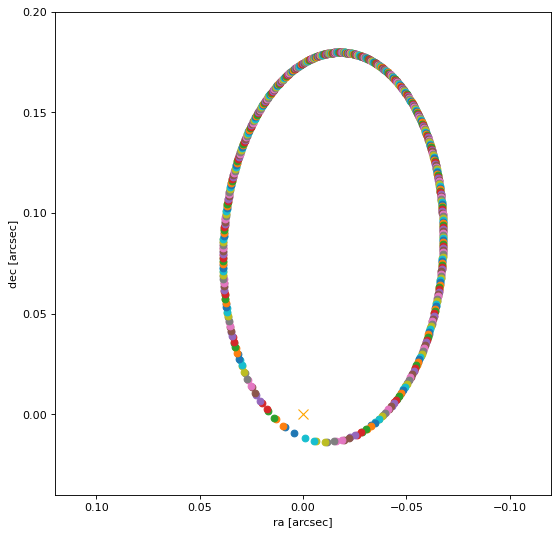

In [52]:
#------------------------------------------------
#exercise 8.2
#------------------------------------------------
# plot DEC vs RA for 2 revolutions

ra = np.zeros(1000)
dec = np.zeros(1000)
rv = np.zeros(1000)
plt.figure(figsize=(8, 8), dpi=80)
for iii,tt in enumerate(t):
    ra[iii],dec[iii],rv[iii] = find_coord(tt, M, D, P, T0, e, inc, om, Om)
    plt.scatter(ra[iii],dec[iii])
plt.plot(0,0,'x', ms = 9, color = 'orange')
plt.xlim(0.12, -0.12)
plt.ylim(-0.04, 0.2)
plt.xlabel('ra [arcsec]')
plt.ylabel('dec [arcsec]')
plt.show()



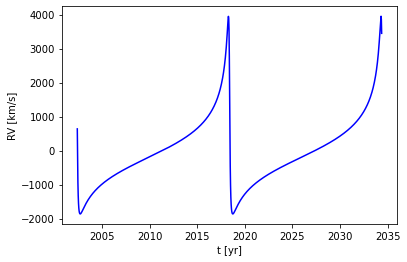

In [53]:
# plot RV vs t for 2 revolutions

plt.plot(t,rv, color = 'blue')
plt.xlabel('t [yr]')
plt.ylabel('RV [km/s]')
plt.show()

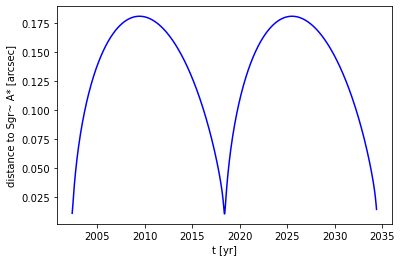

In [54]:
# plot distance to the black hole vs t for 2 revolutions

plt.plot(t,np.sqrt(ra**2.+dec**2.), color = 'blue')
plt.xlabel('t [yr]')
plt.ylabel('distance to Sgr~ A* [arcsec]')
plt.show()

In [55]:
#------------------------------------------------
#exercise 8.3
#------------------------------------------------
# generate a realistic obersvation cadence between 2003 and 2018

bn = np.random.binomial(1, 0.60, 16)
print(bn)
t = np.array([])
for i in range(0,16):
    t = np.append(t,i + np.random.uniform(0.254,0.626,3+bn[i]) + 2003)
    
t_closest_approach = T0 + 0.1 * (2*np.random.random(8)-1.)
t = np.sort(np.append(t,t_closest_approach))
print(t)

[1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0]
[2003.42931394 2003.45637779 2003.56783425 2003.57624271 2004.32331916
 2004.3670948  2004.40584011 2004.55133249 2005.32593717 2005.38751135
 2005.4942568  2005.55404913 2006.4041245  2006.50692298 2006.55072375
 2006.60043497 2007.38326956 2007.55197407 2007.56055441 2008.28660468
 2008.39183051 2008.40481407 2008.62506886 2009.38973336 2009.52705344
 2009.56540428 2009.60922135 2010.262485   2010.3493177  2010.59741046
 2011.3890682  2011.46246288 2011.52454494 2011.58052407 2012.3517885
 2012.52434783 2012.61723281 2013.44965594 2013.50356984 2013.57029058
 2014.39739446 2014.44102236 2014.52794631 2015.37751337 2015.40336314
 2015.53740721 2016.26569416 2016.54087799 2016.55844354 2017.35041634
 2017.47518332 2017.48670244 2018.28740148 2018.31533367 2018.33017521
 2018.34173362 2018.36009006 2018.36765909 2018.37809753 2018.4222593
 2018.4320823  2018.44016682 2018.46703062]


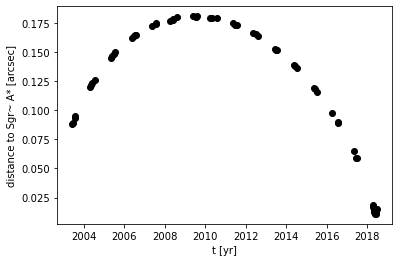

In [56]:
# generate mock data and plot diagnostics

ra = np.zeros(t.size)
dec = np.zeros(t.size)
rv = np.zeros(t.size)
ra_err = np.zeros(t.size)
dec_err = np.zeros(t.size)
rv_err = np.zeros(t.size)

plt.figure(figsize=(8, 8), dpi=80)
for iii,tt in enumerate(t):
    ra[iii],dec[iii],rv[iii] = find_coord(tt, M, D, P, T0, e, inc, om, Om)
    
ra += np.random.normal(0.0, 0.0006, t.size)
dec += np.random.normal(0.0, 0.0006, t.size)
rv += np.random.normal(0.0, 25.0, t.size)

ra_err[:] = 0.0006
dec_err[:] = 0.0006
rv_err[:] = 25.0

plt.scatter(ra,dec, color = 'black')
plt.plot(0,0,'x', ms = 9, color = 'orange')
plt.xlim(0.12, -0.12)
plt.ylim(-0.04, 0.2)
plt.xlabel('ra [arcsec]')
plt.ylabel('dec [arcsec]')
plt.show()

plt.scatter(t,rv, color = 'black')
plt.xlabel('t [yr]')
plt.ylabel('RV [km/s]')
plt.show()

plt.scatter(t,np.sqrt(ra**2.+dec**2.), color = 'black')
plt.xlabel('t [yr]')
plt.ylabel('distance to Sgr~ A* [arcsec]')
plt.show()

In [57]:
#------------------------------------------------
#exercise 8.4
#------------------------------------------------
#chi square fit with scipy.optimize.curve_fit

#orbital elements
D = 7959
M = 3.975e6
P = 16.042
T0 = 2018.3763
e = 0.8858
inc = 133.82
om = 66.11
Om = 227.49

#perpare array shape
ydata = np.array([ra,dec,rv]).T.flatten()
y_err = np.array([ra_err,dec_err,rv_err]).T.flatten()
print(t.shape,ydata.shape)

#set initial values and boundaries
p0 = None #np.array([4.0e6, 7500 , 16.0, 2018.3, 0.9, 120.0, 70., 230.])
bounds = ([2.0e6,7000,1.0,2002.0,0.0, 0.0, 0.0, 0.0],[5.0e6,8500,100.0,2025.0, 1.0, 180.0, 90.0, 360.0]) 

#run the fitter
popt, pcov = optimize.curve_fit(wrap_find_coord, t, ydata, sigma = y_err, p0 = p0, bounds = bounds,\
                                absolute_sigma = False)

(63,) (189,)


In [58]:
#print results

param = np.array([3.975e6,7959,16.042,2018.3763,0.8858,133.82,66.11,227.49])
perr = np.sqrt(np.diag(pcov))

for i in range(len(param)):
    print(param[i],popt[i], perr[i], (perr[i]/popt[i]), (abs(param[i]-popt[i])/param[i]))


3975000.0 3922047.432441337 69054.0925246745 0.017606643905805786 0.013321400643688797
7959.0 7889.761676886455 66.22264132210042 0.00839349070785037 0.008699374684450992
16.042 16.0264676082743 0.008046876964202095 0.0005020992249126423 0.0009682328715685615
2018.3763 2018.3758700958795 0.0005486543404446989 2.718296173539946e-07 2.129950299345275e-07
0.8858 0.885427273818527 0.0004160478170127791 0.0004698836700822594 0.00042077916174417836
133.82 133.4763999236441 0.19680532913169038 0.0014744578760310732 0.0025676287278127183
66.11 65.94565499352942 0.15811639981631093 0.0023976772970383765 0.0024859326345573005
227.49 227.0991775734949 0.2052420045133482 0.0009037549440130704 0.001717976291288014


(1000, 3)


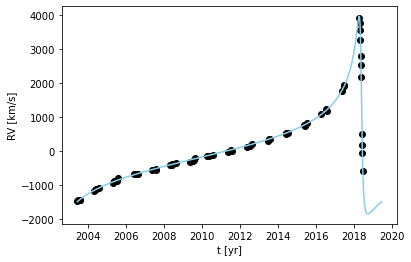

In [59]:
#plot results

ttt = (np.linspace(-popt[2],0,1000) + popt[3])
ttt += -min(ttt)+min(t)

yyy = wrap_find_coord(ttt, *popt)

yyy = yyy.reshape(ttt.size,3)
print(yyy.shape)


plt.figure(figsize=(8, 8), dpi=80)
plt.plot(yyy[:,0], yyy[:,1], color = 'skyblue')

plt.scatter(ra,dec, color = 'black')
plt.plot(0,0,'x', ms = 9, color = 'orange')
plt.xlabel('ra [arcsec]')
plt.ylabel('dec [arcsec]')
#plt.legend()
plt.xlim(0.12, -0.12)
plt.ylim(-0.04, 0.2)
plt.show()

plt.plot(ttt, yyy[:,2], color = 'skyblue')
plt.scatter(t,rv, color = 'black')
plt.xlabel('t [yr]')
plt.ylabel('RV [km/s]')
plt.show()

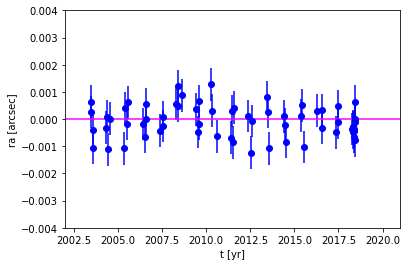

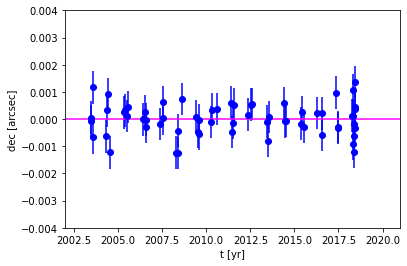

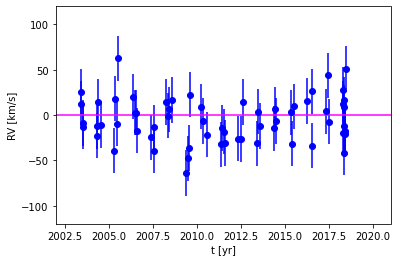

In [60]:
#plot residuals

yyyy = wrap_find_coord(t, *popt)
yyyy = yyyy.reshape(t.size,3)
plt.errorbar(t,ra-yyyy[:,0], yerr = ra_err, fmt="o", color = 'blue')
plt.axhline(y=0.0, color='magenta', linestyle='-')
plt.xlim(2002,2021)
plt.ylim(-0.004, 0.004)
plt.xlabel('t [yr]')
plt.ylabel('ra [arcsec]')
plt.show()

plt.errorbar(t,dec-yyyy[:,1], yerr = dec_err, fmt="o", color = 'blue')
plt.axhline(y=0.0, color='magenta', linestyle='-')
plt.xlim(2002,2021)
plt.ylim(-0.004, 0.004)
plt.xlabel('t [yr]')
plt.ylabel('dec [arcsec]')
plt.show()

plt.errorbar(t,rv-yyyy[:,2], yerr = rv_err, fmt="o", color = 'blue')
plt.axhline(y=0.0, color='magenta', linestyle='-')
plt.xlim(2002,2021)
plt.ylim(-120., 120.)
plt.xlabel('t [yr]')
plt.ylabel('RV [km/s]')
plt.show()

In [61]:
#load input parameters and fit results into Pandas DF 

df_chi2 = pd.DataFrame(np.array([param, popt, perr]).T, columns = ['input', 'best fit', 'error']\
                  , index=['M','D','P','T0','e','inc','om','Om']) 
print(df_chi2)

            input      best fit         error
M    3.975000e+06  3.922047e+06  69054.092525
D    7.959000e+03  7.889762e+03     66.222641
P    1.604200e+01  1.602647e+01      0.008047
T0   2.018376e+03  2.018376e+03      0.000549
e    8.858000e-01  8.854273e-01      0.000416
inc  1.338200e+02  1.334764e+02      0.196805
om   6.611000e+01  6.594565e+01      0.158116
Om   2.274900e+02  2.270992e+02      0.205242


In [62]:
#Calculate fractional fit error and deviation from ground truth and print out nicely

df_chi2['fractional err'] = (df_chi2['error']/df_chi2['best fit'])
df_chi2['frac. diff. input - best fit'] = (abs(df_chi2['input']-df_chi2['best fit'])/df_chi2['input'])

format_dict = {
    'input': '{:.4f}',
    'best fit': '{:.4f}',
    'error': '{:.4f}',
    'fractional err': '{:.2%}',
    'frac. diff. input - best fit': '{:.2%}'}
display(df_chi2.style.format(formatter = format_dict))

In [63]:
#------------------------------------------------
#exercise 8.5 - Likelihood minimization
#------------------------------------------------
# function for Gaussian log-likelihood estimation

#@jit(nopython=True)
def log_likelihood(param, t, ra, dec, rv, ra_err, dec_err, rv_err):
    model = wrap_find_coord(t, *param)
    ydata = np.array([ra,dec,rv]).T.flatten()
    y_err = np.array([ra_err,dec_err,rv_err]).T.flatten()
    sigma2 = y_err**2.
    return -0.5 * np.sum((ydata - model) ** 2 / sigma2 + np.log(sigma2))


In [64]:
#maximization of likelihood with scipy.optimize.minimize

p0 = np.array([4.0e6, 7500 , 16.0, 2018.3, 0.9, 120.0, 70., 230.])
bounds = np.array(((2.0e6,5.0e6),(7000,8500),(1.0,100.0),(2002.0,2025.0),(0.0,1.0),(0.0, 180.0),\
                   (0.0, 90.0),(0.0, 360.0)))
nll = lambda *args: -log_likelihood(*args)
soln = optimize.minimize(nll, p0, args=(t, ra, dec, rv, ra_err, dec_err, rv_err), bounds = bounds)
p_MLE = soln.x

In [65]:
# display of results via Pandas

df_MLE = pd.DataFrame(np.array([param, p_MLE]).T, columns = ['input', 'MLE']\
                  , index=['M','D','P','T0','e','inc','om','Om']) 

df_MLE['frac. diff. input - MLE'] = (abs(df_MLE['input']-df_MLE['MLE'])/df_MLE['input'])

format_dict = {
    'input': '{:.4f}',
    'best fit': '{:.4f}',
    'error': '{:.4f}',
    'frac. diff. input - MLE': '{:.2%}'}
display(df_MLE.style.format(formatter = format_dict))

(1000, 3)


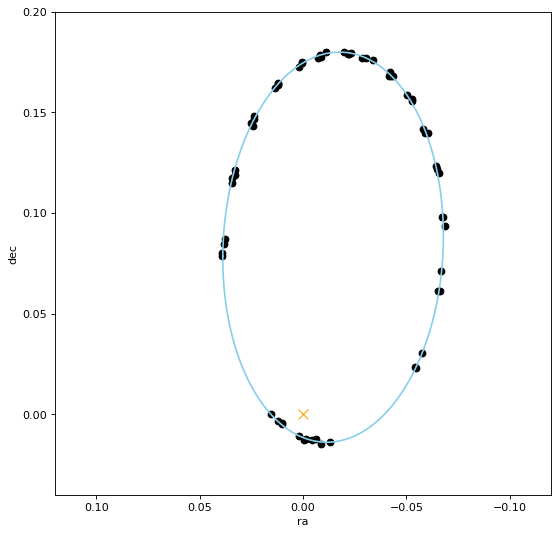

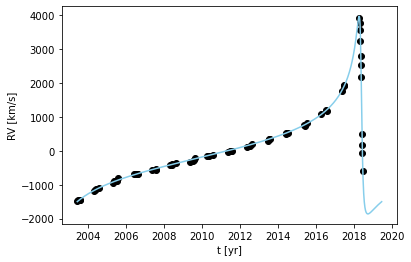

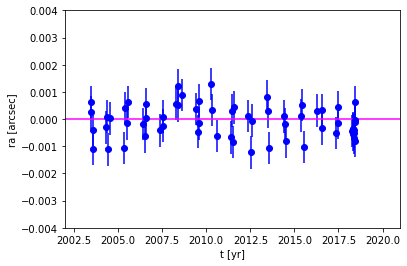

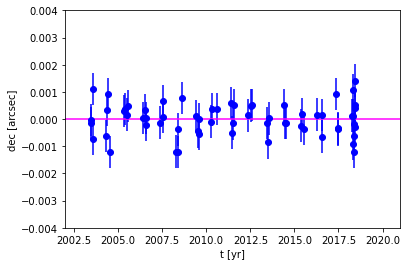

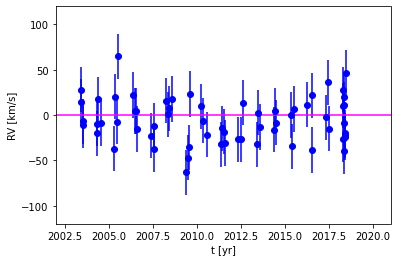

In [66]:
# plot results

ttt = (np.linspace(-popt[2],0,1000) + popt[3])
ttt += -min(ttt)+min(t)

yyy = wrap_find_coord(ttt, *p_MLE)

yyy = yyy.reshape(ttt.size,3)
print(yyy.shape)


plt.figure(figsize=(8, 8), dpi=80)
plt.plot(yyy[:,0], yyy[:,1], color = 'skyblue')

plt.scatter(ra,dec, color = 'black')
plt.plot(0,0,'x', ms = 9, color = 'orange')
plt.xlabel('ra')
plt.ylabel('dec')
#plt.legend()
plt.xlim(0.12, -0.12)
plt.ylim(-0.04, 0.2)
plt.show()

plt.plot(ttt, yyy[:,2], color = 'skyblue')
plt.scatter(t,rv, color = 'black')
plt.xlabel('t [yr]')
plt.ylabel('RV [km/s]')
plt.show()

yyyy = wrap_find_coord(t, *p_MLE)
yyyy = yyyy.reshape(t.size,3)
plt.errorbar(t,ra-yyyy[:,0], yerr = ra_err, fmt="o", color = 'blue')
plt.axhline(y=0.0, color='magenta', linestyle='-')
plt.xlim(2002,2021)
plt.ylim(-0.004, 0.004)
plt.xlabel('t [yr]')
plt.ylabel('ra [arcsec]')
plt.show()

plt.errorbar(t,dec-yyyy[:,1], yerr = dec_err, fmt="o", color = 'blue')
plt.axhline(y=0.0, color='magenta', linestyle='-')
plt.xlim(2002,2021)
plt.ylim(-0.004, 0.004)
plt.xlabel('t [yr]')
plt.ylabel('dec [arcsec]')
plt.show()

plt.errorbar(t,rv-yyyy[:,2], yerr = rv_err, fmt="o", color = 'blue')
plt.axhline(y=0.0, color='magenta', linestyle='-')
plt.xlim(2002,2021)
plt.ylim(-120., 120.)
plt.xlabel('t [yr]')
plt.ylabel('RV [km/s]')
plt.show()

In [67]:
#------------------------------------------------
#exercise 8.6 MCMC sampling of posterior
#------------------------------------------------
# function for logarithm of flat prior within boundaries

#@jit(nopython=True)
def log_flat_prior(param, bounds):
    if bounds[0,0] < param[0] < bounds[0,1] and \
        bounds[1,0] < param[1] < bounds[1,1] and \
        bounds[2,0] < param[2] < bounds[2,1] and \
        bounds[3,0] < param[3] < bounds[3,1] and \
        bounds[4,0] < param[4] < bounds[4,1] and \
        bounds[5,0] < param[5] < bounds[5,1] and \
        bounds[6,0] < param[6] < bounds[6,1] and \
        bounds[7,0] < param[7] < bounds[7,1]:
        return 0.0
    return -np.inf

In [68]:
#multiply prior and likelihood

#@jit(nopython=True)
def log_probability(param, t, ra, dec, rv, ra_err, dec_err, rv_err, bounds):
    lp = log_flat_prior(param,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(param, t, ra, dec, rv, ra_err, dec_err, rv_err)

In [69]:
# setup and run sampler like in Problem 6

nwalkers = 32
ndim = 8
bounds = np.array(((2.0e6,5.0e6),(7000,8500),(1.0,100.0),(2002.0,2025.0),(0.0,1.0),(0.0, 180.0),\
                   (0.0, 90.0),(0.0, 360.0)))

#sample around the maximum likelihood solution
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(\
#         nwalkers, ndim, log_probability, args=((t, ra, dec, rv, ra_err, dec_err, rv_err, bounds)), pool=pool)
#     state = sampler.run_mcmc(pos, 100)
#     sampler.reset()
#     sampler.run_mcmc(state, 7000, progress=True);

In [71]:
# save variable 'sampler' to disk; read pickled variable if no time to run sampler

#with open('sampler.pickle','wb') as f:
#    pickle.dump(sampler, f)
    
with open('sampler.pickle', 'rb') as f:
    sampler = pickle.load(f)

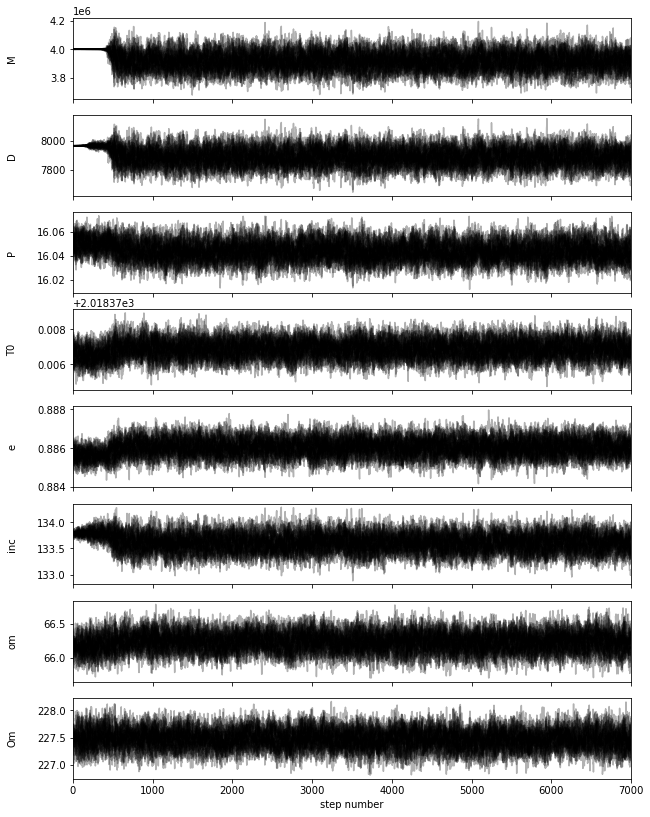

In [72]:
# plot paramter values as function of step

fig, axes = plt.subplots(8, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = list(df_MLE.index.values)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [73]:
# print coherence timescale

tau = sampler.get_autocorr_time()
print(tau)

[129.61336295 129.8092806  109.66489464  87.95022369 104.39629262
 120.40677049  93.80080367  92.19068915]


In [74]:
# pepare chain for further use

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(14720, 8)


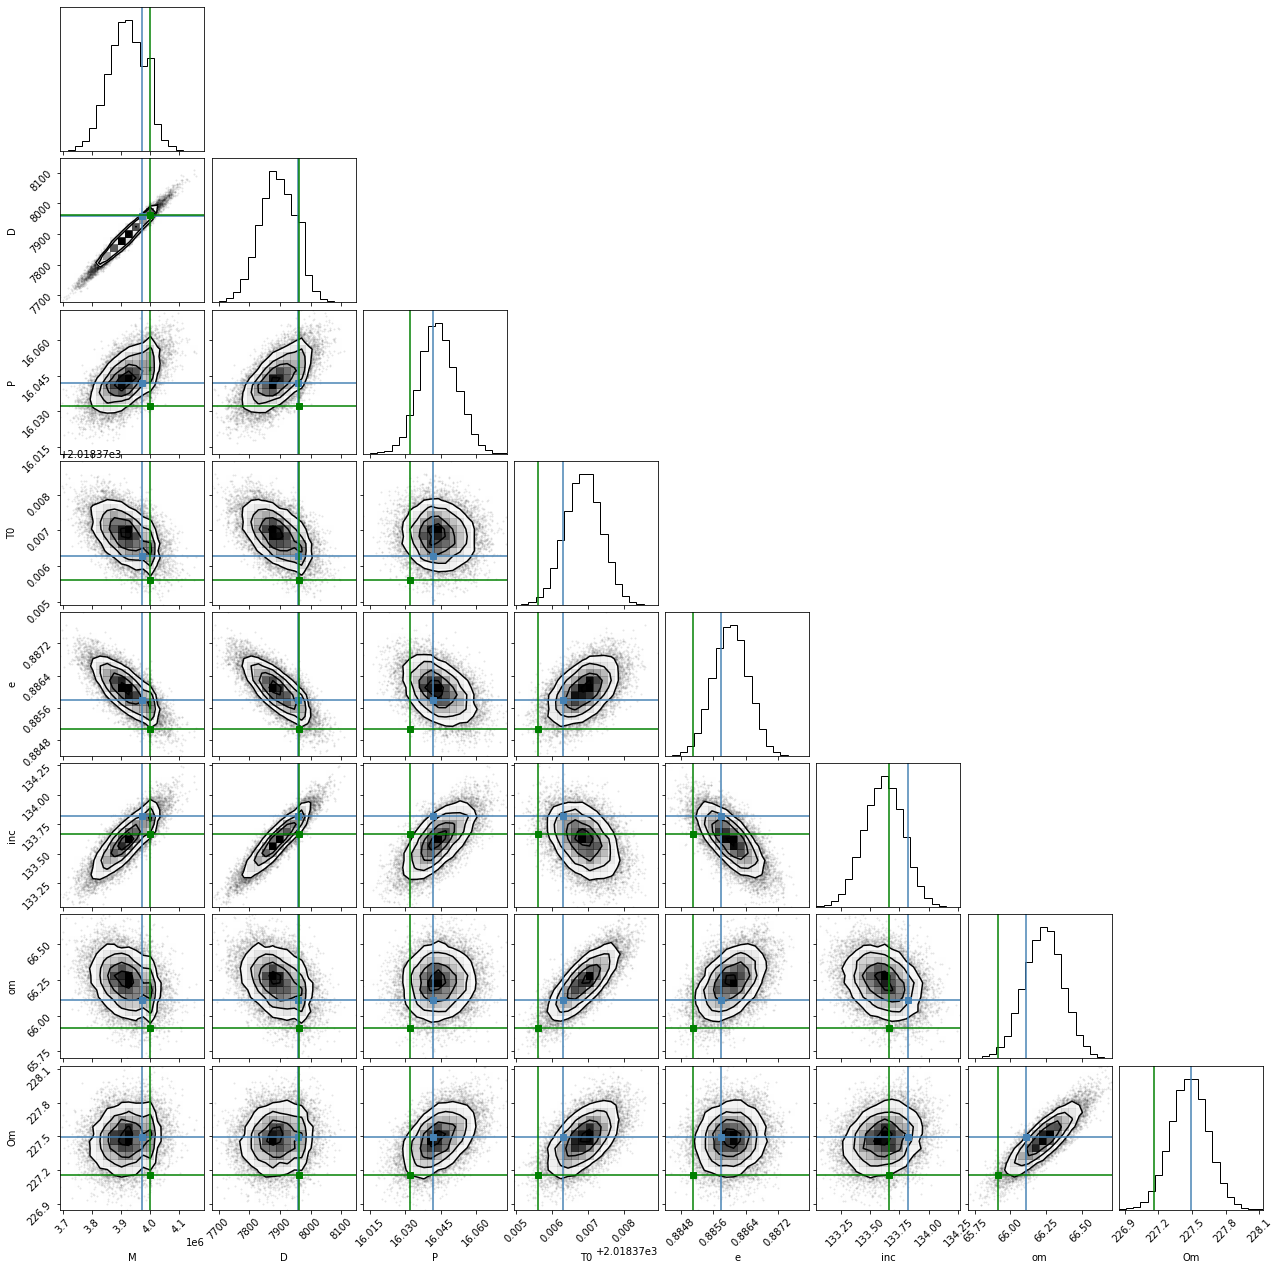

In [75]:
#Plot corner plot
ndim = 8
fig = corner.corner(
    flat_samples, labels=labels, truths=list(param)
);
# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(p_MLE[i], color="g")

    
# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(p_MLE[xi], color="g")
        ax.axhline(p_MLE[yi], color="g")
        ax.plot(p_MLE[xi], p_MLE[yi], "sg")


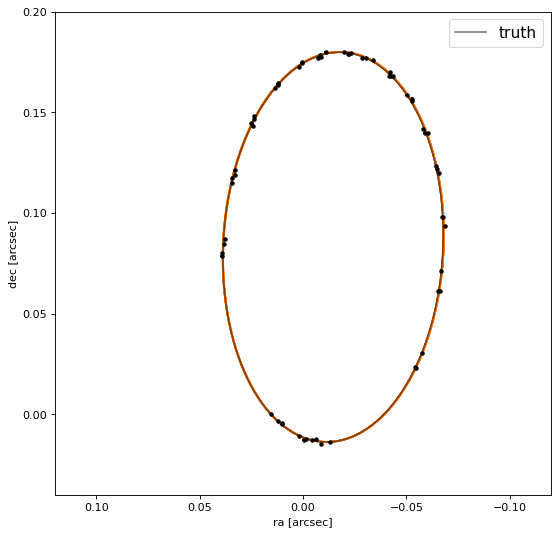

In [76]:
#over-plot results onto mock data

plt.figure(figsize=(8, 8), dpi=80)
inds = np.random.randint(len(flat_samples), size=100)
y_truth = wrap_find_coord(ttt, *param)
y_truth = y_truth.reshape(ttt.size,3)

for ind in inds:
    sample = flat_samples[ind]
    y_pos = wrap_find_coord(ttt, *sample)
    y_pos = y_pos.reshape(ttt.size,3)
    plt.plot(y_pos[:,0], y_pos[:,1], "C1", alpha=0.1)
plt.errorbar(ra, dec, xerr= ra_err, yerr=dec_err, fmt=".k", capsize=0)
plt.plot(y_truth[:,0], y_truth[:,1], "k", label="truth", alpha = 0.5)
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel('ra [arcsec]')
plt.ylabel('dec [arcsec]')
#plt.legend()
plt.xlim(0.12, -0.12)
plt.ylim(-0.04, 0.2)
plt.show();

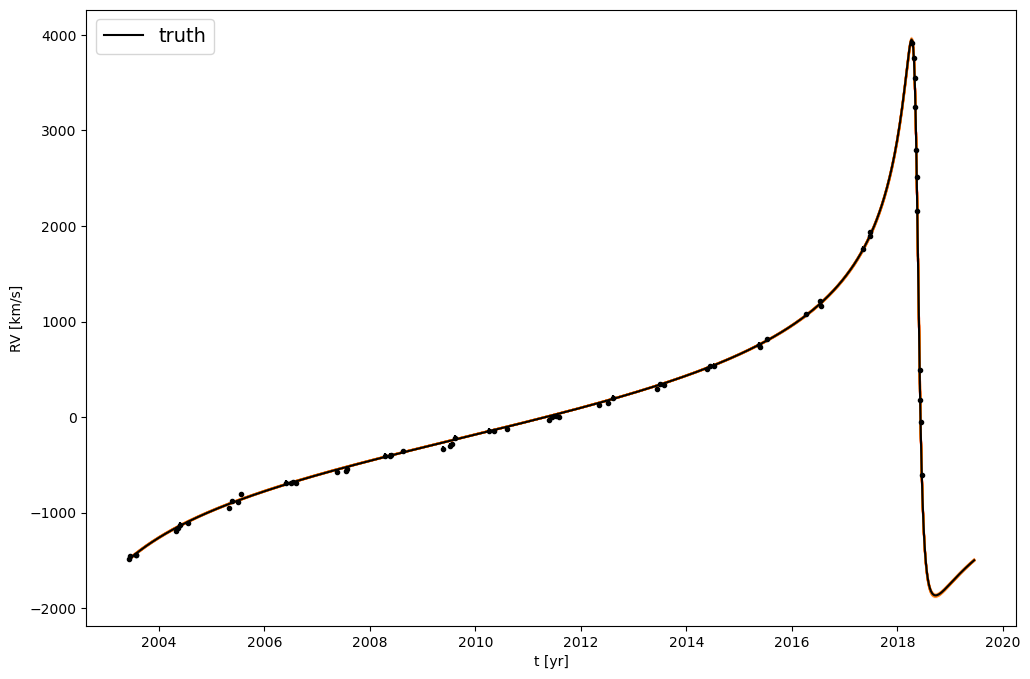

In [89]:
#over-plot results onto mock data

plt.errorbar(t, rv, yerr=rv_err, fmt=".k", capsize=0)
for ind in inds:
    sample = flat_samples[ind]
    y_pos = wrap_find_coord(ttt, *sample)
    y_pos = y_pos.reshape(ttt.size,3)
    plt.plot(ttt, y_pos[:,2], "C1", alpha=0.1)
plt.plot(ttt, y_truth[:,2],"k", label="truth", alpha = 1.0)
plt.legend(fontsize=14)
plt.xlabel('t [yr]')
plt.ylabel('RV [km/s]')
plt.show()

In [78]:
# print out precentiles nicely

mcmc = np.zeros((ndim,3))
for i in range(ndim):
    mcmc[i,:] = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc[i])
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[i,1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [79]:
# display as Pandas table

df_MCMC = pd.DataFrame(np.array([param, mcmc[:,0], np.diff(mcmc).mean(axis=1)]).T, \
                    columns = ['input', 'MCMC', 'width of posterior'], index=['M','D','P','T0','e','inc','om','Om']) 

df_MCMC['fractional err'] = (df_MCMC['width of posterior']/df_MCMC['MCMC'])
df_MCMC['frac. diff. input - MCMC'] = (abs(df_MCMC['input']-df_MCMC['MCMC'])/df_MCMC['input'])

format_dict = {
    'input': '{:.4f}',
    'MCMC': '{:.4f}',
    'width of posterior': '{:.4f}',
    'fractional err': '{:.2%}',
    'frac. diff. input - MCMC': '{:.2%}'}
display(df_MCMC.style.format(formatter = format_dict))

# Addendum - Covariance matrix and correlated noise - decorrelation by affine transformation
# from https://datascienceplus.com/understanding-the-covariance-matrix where you can find more information and explanation

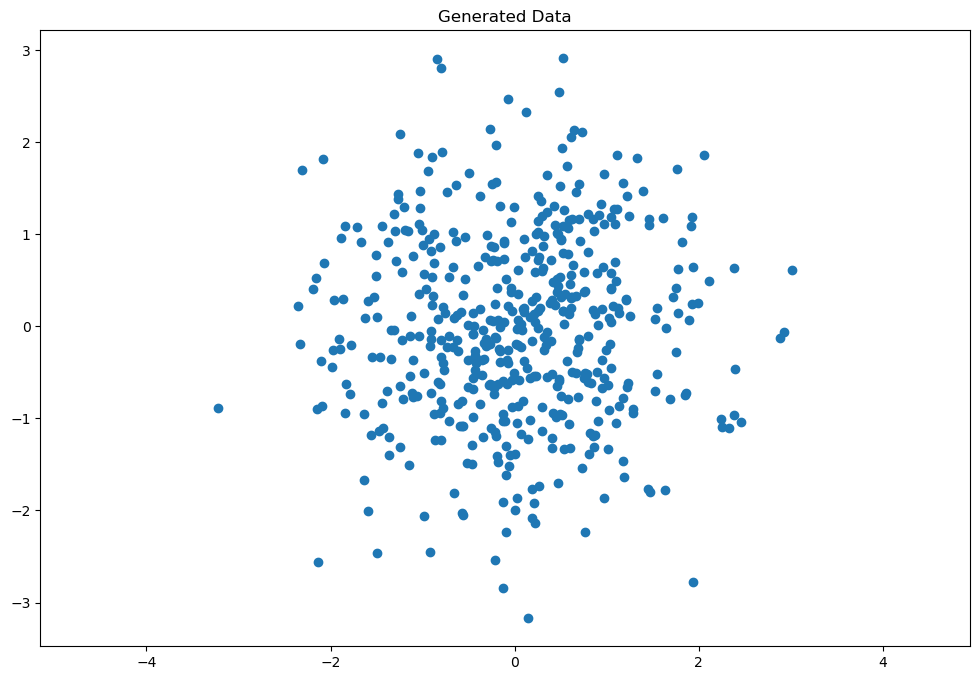

In [88]:
#plt.style.use('ggplot')
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['figure.figsize'] = (12, 8)

# Normal distributed x and y vector with mean 0 and standard deviation 1
x = np.random.normal(0, 1, 500)
y = np.random.normal(0, 1, 500)
X = np.vstack((x, y)).T

plt.scatter(X[:, 0], X[:, 1])
plt.title('Generated Data')
plt.axis('equal');


In [90]:
# Covariance
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                     [cov(X[1], X[0]), cov(X[1], X[1])]])

# Calculate covariance matrix 
cov_mat(X.T) # (or with np.cov(X.T))


array([[1.02166669, 0.03879291],
       [0.03879291, 1.04944672]])

array([[ 0.50061668,  0.09232713],
       [ 0.09232713, 12.13160411]])

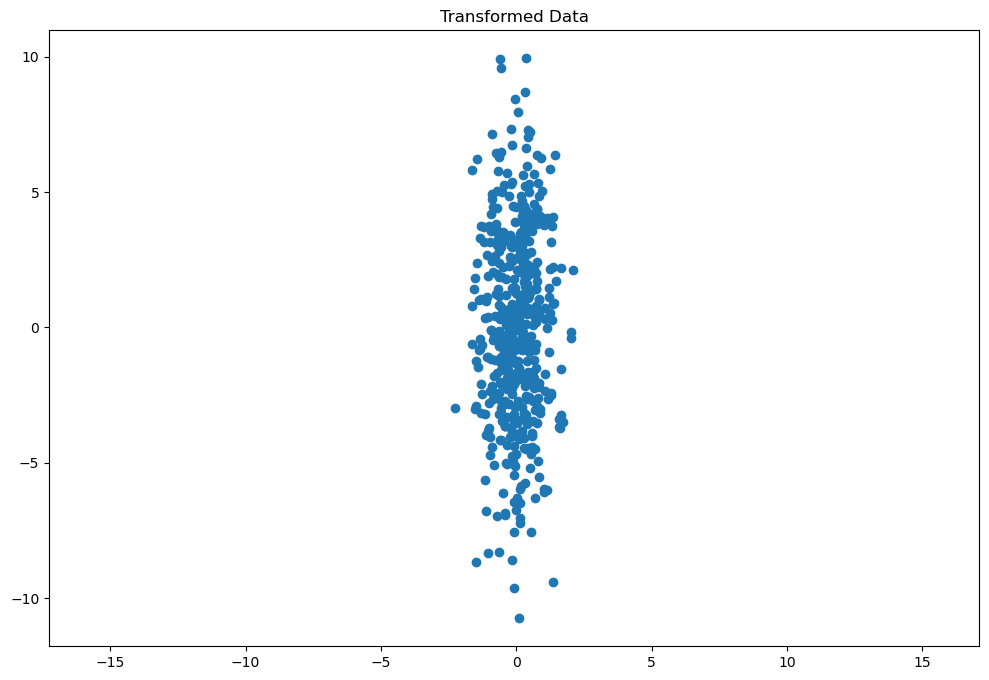

In [91]:
# Center the matrix at the origin
X = X - np.mean(X, 0)

# Scaling matrix
sx, sy = 0.7, 3.4
Scale = np.array([[sx, 0], [0, sy]])

# Apply scaling matrix to X
Y = X.dot(Scale)

plt.scatter(Y[:, 0], Y[:, 1])
plt.title('Transformed Data')
plt.axis('equal')

# Calculate covariance matrix
cov_mat(Y.T)


array([[ 5.49563666, -5.75806515],
       [-5.75806515,  7.13658412]])

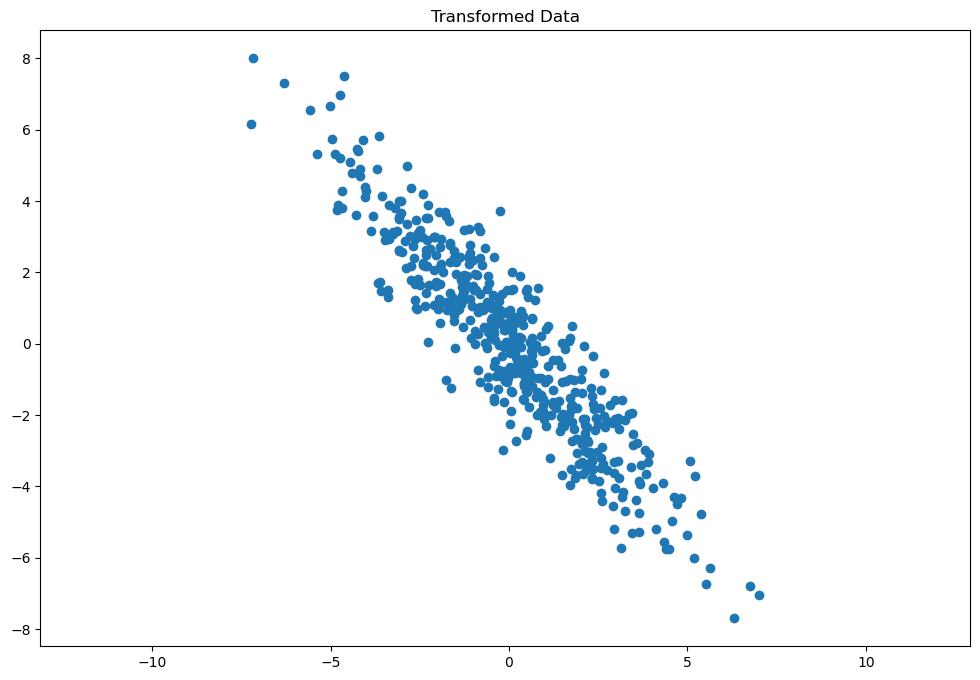

In [92]:
# Scaling matrix
sx, sy = 0.7, 3.4
Scale = np.array([[sx, 0], [0, sy]])

# Rotation matrix
theta = 0.77*np.pi
c, s = np.cos(theta), np.sin(theta)
Rot = np.array([[c, -s], [s, c]])

# Transformation matrix
T = Scale.dot(Rot)

# Apply transformation matrix to X
Y = X.dot(T)

plt.scatter(Y[:, 0], Y[:, 1])
plt.title('Transformed Data')
plt.axis('equal');

# Calculate covariance matrix
cov_mat(Y.T)


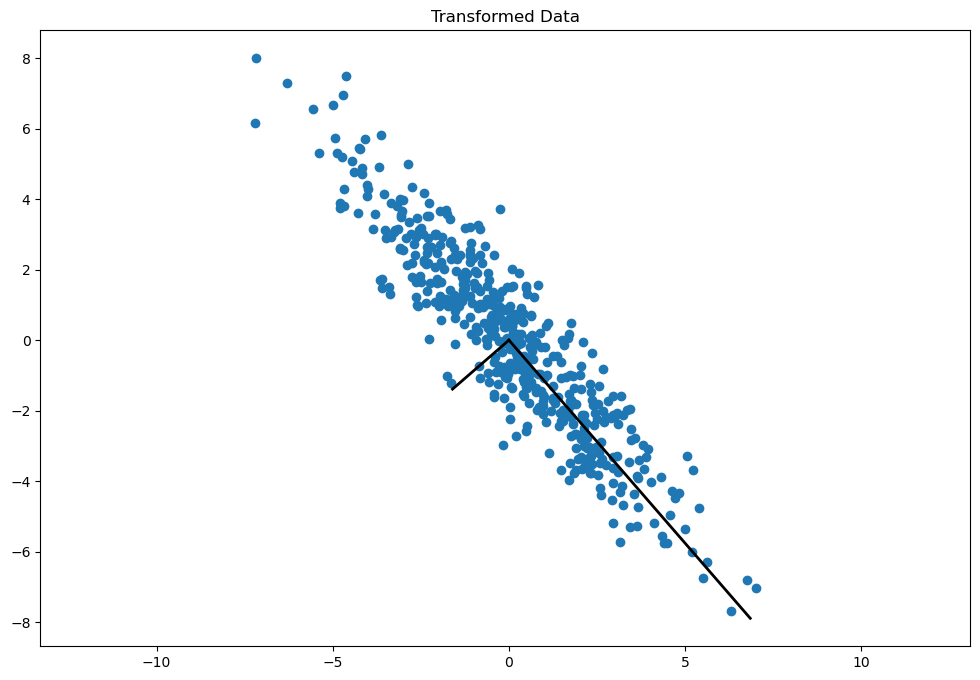

In [93]:
C = cov_mat(Y.T)
eVe, eVa = np.linalg.eig(C)

plt.scatter(Y[:, 0], Y[:, 1])
for e, v in zip(eVe, eVa.T):
    plt.plot([0, 3*np.sqrt(e)*v[0]], [0, 3*np.sqrt(e)*v[1]], 'k-', lw=2)
plt.title('Transformed Data')
plt.axis('equal');


array([[ 1.00000e+00, -1.28154e-16],
       [-1.28154e-16,  1.00000e+00]])

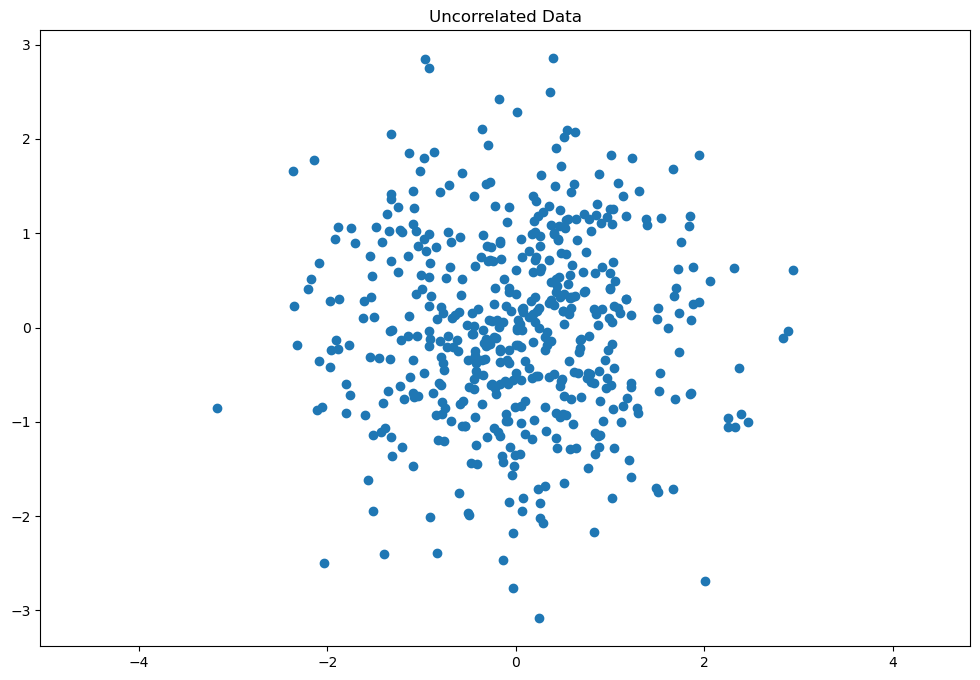

In [94]:
C = cov_mat(Y.T)

# Calculate eigenvalues
eVa, eVe = np.linalg.eig(C)

# Calculate transformation matrix from eigen decomposition
R, S = eVe, np.diag(np.sqrt(eVa))
T = R.dot(S).T

# Transform data with inverse transformation matrix T^-1
Z = Y.dot(np.linalg.inv(T))

plt.scatter(Z[:, 0], Z[:, 1])
plt.title('Uncorrelated Data')
plt.axis('equal');

# Covariance matrix of the uncorrelated data
cov_mat(Z.T)